#  Classification of Music Lyrics by Genre


__`MIDS w266: Natural Language Processing and Deep Learning | UC Berkeley School of Information | Summer 2019`__

_Team members_

  - __Dan Price__, danprice@ischool.berkeley.edu
  - __Shiraz Chakraverty__, schakraverty@berkeley.edu

  
## Table of Contents

[1.Abstract](#1.-Abstract)

[2.Introduction](#2.-Introduction)

[3.Background](#3.-Background)

[3.EDA and discussion of challenges](#3.-EDA-and-discussion-of-challenges)

[4.Methods (design and implementation)](#4.-Methods)

[5. Application of New Concepts](#5.-Application-of-New-Concepts)

[References](#6.-References)

__Please render this notebook with `jupyter` or `nbviewer`. The github notebook viewer does not render all equations correctly.__

# 1. Abstract


"CD sales are plummeting, and vinyl sales have plateaued after rising to their greatest peak since the 1990s, but that doesn't mean that people have stopped listening to music. With the rise of streaming music, people are listening as much as ever, in their homes, offices, or any other location where their devices can connect to the internet." - Says PCMag<sup>[1]</sup>

Spotify<sup>[2]</sup>, happens to have total market share of over $25 Billion, and is one of the leaders in the music streaming space today. It has millions of songs in its database and claims at its core that it has the right music for everyone. They have invested a lot in research, especially NLP methods, starting with classification of the music based on many factors including tempo, acoustics, energy, danceability etc. to answer that most important and stressful first impression question: What is your favorite type of music?

Companies like spotify are surviving based on more and more nuanced music classification, either to be able to place the right recommendations to their customers or simply as a product (for example Shazam). Thus finding out at scale, the music genres is the most fundamental step in moving towards a personal listening experience.

# 2. Introduction

Various academic and industry teams have tried approaches to this space. Efforts to understand music, both sonically and semantically through lyrics and metadata, have coalesced in a subfield known as Music Information Retrieval (MIR). No single effort has been very successful in finding a stable method which performs significantly well to tackle the lyrical genre classification problem. SVM, KNN and Naive Bayes have all been used in lyrical classification but they all have very low accuracy. We would like to explore the application of new and emerging models to the task.

In the field of Natural Language Processing, the classification of music genres based on lyrics is a challenging task. Machine understanding of language in general is complex. We cannot yet fully understand how the human brain does it but many strides have been made. With that understanding, newer and emerging algorithms and word embeddings are able to offer classifications useful for organizations doing language tasks at a large scale. 

We would like to explore advantages and disadvantages of several methods in papers we have selected and report our observations, learnings and a recommendation. With the focus of deep learning, it is clear that Neural Networks tend to work better than previously used models. We would like to explore this path and provide some comparative analysis. 

The dataset for this problem is hard to come by  due to copyright and other original content protection requirements. The search for more examples continues, in the meantime we have we found a data set in Kaggle which is suitable to get started with model development.

The initial dataset is downloadable as a comma delimited file. The columns in the file are as follows:
`index,song,year,artist,genre,lyrics`
    
We are particularly interested in the text in the lyrics column. However, we may find ways to utilize other columns as features. The lyrics are a string with carriage returns denoting an end of line. Statistics specific to the overall structure of the lyrics, such as line length, may add value to the classification task.

# 3. Background


__[to be done] - this section needs to capture a summary of the literature we used with reference citations, methods we chose, etc
[the following is a sample only]__

The algorithm is based on Logistic Regression. We follow the development and notation of [Chapelle et al.,](https://www.dropbox.com/s/s4x7wp8gjsh021d/TISTRespPredAds-Chappelle-CTR-Prediction-2014Paper.pdf?dl+=0)<sup>[5]</sup> For a given data sample $i$, let $y_i$ be our target variable, namely,  we have

$$
y_i =
\begin{cases}
0 \;\; \text{if user does not click on the ad},\\
1 \;\; \text{otherwise}.
\end{cases}
$$

Let $\mathbf{x}_i$ be the $d$-dimensional one-hot vector, i.e., $\mathbf{x}_i \in \{0,1\}^d$. Our goal is to find the weight vector $\mathbf{w} \in \mathbb{R}^d$. The probability of sample $\mathbf{x}_i$ belonging to class 1 is given by the following.

$$P(y_i=1 | \mathbf{x}_i, \mathbf{w}) = \frac{1}{1+e^{-\mathbf{w}^\top\mathbf{x}_i}}$$

Thus, the probability of sample $\mathbf{x}_i$ belonging to class 0 is given by the following.

$$P(y_i=0 | \mathbf{x}_i, \mathbf{w}) = \frac{e^{-\mathbf{w}^\top\mathbf{x}_i}}{1+e^{-\mathbf{w}^\top\mathbf{x}_i}}$$

The logistic regression model is a linear model of the log odds ratio, namely, we have the following.

$$\log \frac{P(y_i=1 | \mathbf{x}_i, \mathbf{w})}{P(y_i=0 | \mathbf{x}_i, \mathbf{w})} = \log \frac{1}{e^{-\mathbf{w}^\top\mathbf{x}_i}} = \log e^{\mathbf{w}^\top\mathbf{x}_i}= \mathbf{w}^\top\mathbf{x}_i $$

The weight factor can be calculated via minimizing the negative log likelihood (namely maximize the joined probability across all samples). Also, in order to overcome over fitting, we need to add regularization. Thus, we have the following equation under the $L_2$ regularization.

$$\underset{\mathbf{w}}{\operatorname{argmin}} \left( \sum_{i=1}^{n}\left(\log(1+e^{-\mathbf{w}^\top\mathbf{x}_i})+(1-y_i)\mathbf{w}^\top\mathbf{x}_i\right) + \lambda \lVert \mathbf{w} \rVert^2 \right) \tag{1} $$

The above objective function is a convex function and we can leverage Gradient Descent (GD) methods to solve it. The GD can be easily parallelized in a map-reduce framework. Furthermore,
we can derive the gradient of equation (1) as follows.

$$ \nabla_{\boldsymbol{\mathbf{w}}} = \sum_{i=1}^{n}\left( \frac{-\mathbf{x}_i e^{-\mathbf{w}^\top\mathbf{x}_i }}{1+e^{-\mathbf{w}^\top\mathbf{x}_i }} + (1-y_i)\mathbf{x}_i\right)  + 2\lambda \mathbf{w} = \sum_{i=1}^{n} \left( \frac{1}{1+e^{-\mathbf{w}^\top\mathbf{x}_i}} - y_i \right) \mathbf{x}_i   + 2\lambda \mathbf{w} \tag{2}$$ 

Let $\alpha$ be the learning rate, we can iteratively update $\mathbf{w}$ as follows.

$$\mathbf{w}_\text{new} = \mathbf{w}_\text{old} - \alpha \nabla_{\boldsymbol{\mathbf{w}}}$$

To illustrate our algorithm, let us consider the following simple example with two features.

  - Feature $f_1$ is the user identifier, it has two possible values `user1` or `user2`.
  - Feature $f_2$ is the advertise web site url, it can be either `url1`, `url2` or `url3`.
 
Let us use one-hot encoding for these categorical variables as it is standard practice in machine learning for categorical variables. The dimensionality with one-hot coding is $d=\sum_{j=1}^{F} c_f$, where $f$-th feature has $c_f$ values. In the above example, we have $d=5$. Furthermore, each position in one-hot code is referenced by tuple `(feature_id, category_value)`. For example, we have the following vector in our case.

$$[(f_1, \text{user1}), (f_1, \text{user2}), (f_2, \text{url1}), (f_2, \text{url2}), (f_2, \text{url3}) ]$$

Each position in above vector is a binary. 1 means that the referenced feature takes the corresponding value. The following table shows all possible one-hot vector and their corresponding meaning.

| One-Hot vector | $f_1$ | $f_2$ |
| :---: | :---: |    :---: |
| [1,0,1,0,0]  | user1     | url1 |
| [1,0,0,1,0]  | user1     | url2 |
| [1,0,0,0,1]  | user1     | url3 |
| [0,1,1,0,0]  | user2     | url1 |
| [0,1,0,1,0]  | user2     | url2 |
| [0,1,0,0,1]  | user2     | url3 |

## Notebook Set-Up

The following setup demonstrates two distinct yet valuable approaches. We have used the RDD API as well as the Spark 2.0 DataFrame and ML API in this project. The following are the setup elements, in brief:

(1) Python and Spark libraries - 

`NumPy` Provides
,
  1. An array object of arbitrary homogeneous items
  2. Fast mathematical operations over arrays
  3. Linear Algebra, Fourier Transforms, Random Number Generation

`Pandas` Provides,

  1. Intelligent label-based slicing, fancy indexing, and subsetting of large data sets.
  2. Intuitive merging and joining data sets.
  3. Flexible reshaping and pivoting of data sets.

`Matplotlib` Provides a MATLAB-like way of plotting. `pyplot` is mainly intended for interactive plots and simple cases of programmatic
plot generation::

`SparkSession` is the entry point to programming Spark with the Dataset and DataFrame API. A SparkSession can be used create `DataFrame` as tables, execute SQL over tables, cache tables, and read parquet files.

For brevity, we will not list out all the libraries and their functions, this can be easily requested by executing `[name of library]??`

In [1]:
from __future__ import print_function

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import time
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import csv
import os
import sys
from tabulate import tabulate
import seaborn as sns
from nltk.corpus import wordnet
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import svm
#from nltk.stem.porter import *
from stemming.porter2 import stem
from sklearn.metrics import confusion_matrix
import sys
from sklearn.pipeline import Pipeline
import pickle
from sklearn.externals import joblib
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras import optimizers
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [183]:
from datetime import datetime
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
VOCAB_FILE= "uncased_L-12_H-768_A-12/vocab.txt"
INIT_CHECKPOINT = "uncased_L-12_H-768_A-12/bert_model.ckpt"
CONFIG_FILE = "uncased_L-12_H-768_A-12/bert_config.json"

In [2]:
%reload_ext autoreload
%autoreload 2

In [13]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

# 3. EDA and discussion of challenges

__[section needs to be updated]__


The goal of our EDA is to characterize the dimensionality and distribution of our data. While dependent variable in our dataset tells us that the problem at hand can be solved using a binary classification algorithm, EDA helps us confirm model selection and evaluate options for a scalable solution in the Map-Reduce framework. More specifically, we will explore the data to identify the following:

- What is the total number of dimensions?
- What is the distribution of dimensions?
- Does the dataset conform to the assumptions of a Linear Regression statistcal model?
- What is Receiver Operating Characteristic (ROC) curve with all features (i.e., without any feature hashing)?


### Loading the Dataset

In a limited scope and timeframe we can use this chunk of data that represents roughly a week's worth of click through logs captured. From the raw data, we can see that the dataset consists of text delimited by tabs. The first entry is the label (0 or 1, where 0 means the user didn't click on the given ad), while the rest are features associated with the ad. While we can imagine that there could be a whole host of features like device types, browser types, time of day, date, advertisers, ad, platform, company...but we cannot see any of these labels or the underlying values, these have been changed and hence we cannot `infer` based on any domain knowledge, hence the goal in this project will be more on `prediction performance` and `distributed computing scalability and design efficiency`.

Data file strip :  ```0		0	14	6	7132	171	2	2	6		1		6	05db9164	38a947a1	e88a1d4c	8eb9aec7	25c83c98	fbad5c96	3fd38f3b	```



The training data set consists of over 45 million rows with 13 integer and 26 categorical features. The following observations can be made by analyzing a sample:

1. Label data is 0 or 1 making it a good candidate for logistic regression model
2. Sparse matrix - Dataset contains a lot of missing values. These cannot be deleted since missing values for columns are normal for this use case. Our model will have to be able to handle a sparse matrix 
3. Columns 14 onwards are categorical variables, but the majority of the values are missing and each column has thousands of categories. One Hot encoding of these categorical variables will result in a very large number of features (columns). 
4. The correlation matrix of integer features in sample reveal no significant positive or negative correlation between features. This helps ascertain that data conforms with logistic regression assumption of 'little or no multicollinearity between independent variables'. As a result, all independent variables will be used as features within our model. 
5. The integer variable histograms show that these variables are highly skewed to the left, with a few values to the extreme right. This skewed distribution of data should not be an issue since logistic regression does not assume underlying data is normal.
6. A count of outcomes in sample data shows approx. 3:1 ratio between 0 and 1 as outcome (approx. 75% of data has 0 as outcome). Our strategies to handle the sparse matrix will have to pay careful attention to the ratio of outcome variables to ensure minimal bias in model.
7.  Classification models need to be developed with mind to the prior rates of success (click) or failure (not-clicked). If one is much more likely than the other, predicting the more likely class every time will be accurate at the same rate as the likely class. In the case of this data the prior rates are not given, and the description of the data<sup>[2]</sup> specifically indicates that the classes have been sampled at different rates to change the size of the data set. We cannot hope to recover the initial information. Non-clicks comprise approximately 75% of the data we do have, so our classifier will have to do better than 75% accuracy to beat simply predicting "non-click" every time.

#### Project file Handling (pipeline workflow)

This section is for illustrating the benefits of parsing the raw data files methodically. We need to be mindful that Kaggle challenge provides a dataset that is cleaned, formatted and contains some data preprocessing that will be unavailable with model encounters new data. The operating system provides simple Unix raw file reading tools that can be used to move, split, modify (tab to csv) and even do simple EDA like count lines, words, find specific key words etc. the following section tackles these and each step is explained.

(1) Create a storage directory, download and extract the tarball. This section below is to capture the data we have been provided. In production, we will likely grep this from a kafka stream dumping files into a hdfs storage location from where we can safely load the data into our Spark clusters. However before doing these, we still need to capture these files, and be able to perform some basic operations prior to using the Spark application.

In [5]:
#copy file from bucket
!gsutil -m cp gs://266-schakraverty/lyrics.tar .

Copying gs://266-schakraverty/lyrics.tar...
- [1/1 files][309.6 MiB/309.6 MiB] 100% Done                                    
Operation completed over 1 objects/309.6 MiB.                                    


In [7]:
# Run Once - In production, this will move to the data pipeline
# make a data folder & download zipped datafile
#!mkdir data
#!gunzip data/lyrics.tar.gz
!tar -xvf lyrics.tar
#!cp lyrics.csv data/lyrics.csv

./._lyrics.csv
lyrics.csv


(2) Count the total size of the dataset.

In [3]:
#Count the number of records in the raw data
!wc -l lyrics.csv

 9357041 lyrics.csv


In [5]:
lyrics_sample = pd.read_csv('lyrics.csv')
print('Number of Records:',len(lyrics_sample))

Number of Records: 362237


In [13]:
#Pre-processing
def data_cleanup():

#Cleaning up the data
    with open('lyrics.csv', 'r') as inp, open('lyrics_out.csv', 'w') as out:
        writer = csv.writer(out)
        for row in csv.reader(inp):
            writer.writerow(row)

def multi_class_data():
	data_cleanup()

	df = pd.read_csv('lyrics_out.csv')

	#add a new column with word count of the lyrics of a song
	df['word_count'] = df['lyrics'].str.split( ).str.len()

	df["lyrics"] = df['lyrics'].str.lower()

	#remove rows with lyrics count less than 100

	#df = df[df['genre']!="Pop"]
	df = df[df['genre']!="Folk"]
	#df = df[df['genre']!="Jazz"]
	df = df[df['genre']!="R&B"]
	df = df[df['genre']!="Indie"]
	df = df[df['genre']!="Electronic"]
	df = df[df['genre']!="Metal"]

	df = df[df['word_count'] > 100]

	df = df.groupby('genre').head(1000)
	#replace carriage returns
	df = df.replace({'\n': ' '}, regex=True)

	del df['song'],df['year'],df['artist'],df['word_count']
	print (df.head())

	df.to_csv('lyrics_final.csv', index=False)

In [14]:
start = time.time()
multi_class_data()
end = time.time()
print("completed job in:",end - start,"seconds")

   index genre                                             lyrics
0      0   Pop  oh baby, how you doing? you know i'm gonna cut...
1      1   Pop  playin' everything so easy, it's like you seem...
2      2   Pop  if you search for tenderness it isn't hard to ...
3      3   Pop  oh oh oh i, oh oh oh i [verse 1:] if i wrote a...
4      4   Pop  party the people, the people the party it's po...
completed job in: 29.07986617088318 seconds


__explain what is being done above]__

In [15]:
df = pd.read_csv('lyrics_final.csv')
df.replace('?', -9999999, inplace=True)

df.drop(['index'],1, inplace=True)


In [16]:
df.head()

,genre,lyrics
0,Pop,"oh baby, how you doing? you know i'm gonna cut..."
1,Pop,"playin' everything so easy, it's like you seem..."
2,Pop,if you search for tenderness it isn't hard to ...
3,Pop,"oh oh oh i, oh oh oh i [verse 1:] if i wrote a..."
4,Pop,"party the people, the people the party it's po..."


In [53]:
def pre_process():

	print("Processing the data...")
	df = pd.read_csv('lyrics_final.csv')
	df.replace('?', -9999999, inplace=True)

	df.drop(['index'],1, inplace=True)
	
	#dict_genres={'Rock':1, 'Country':2, 'Hip-Hop':3, 'Pop':4, 'Jazz':5}
    
	dict_genres={genre:index for index,genre in enumerate(df.genre.value_counts().keys())}
    
	labels = []
	text = []
	for index, row in df.iterrows():
		labels.append(row[0])
		words = row[1].split()
		text.append(row[1])
		#text.append(words)
	#stemming
	text = [[stem(word) for word in sentence.split(" ")] for sentence in text]
	text = [" ".join(sentence) for sentence in text]

	print("Data processing done!!")
	return text,labels,dict_genres


def build_dataset(text,labels):
	#text, labels = pre_process()
	
	print("Total songs: %s"%(len(labels)))
	countVec = TfidfVectorizer(stop_words = 'english', sublinear_tf=True)

	#countVec = CountVectorizer(stop_words = 'english')

	x_train, x_test, y_train, y_test = train_test_split(text,labels,test_size=0.2)

	#Creating tf-idf vector for the documents

	x_trainCV = countVec.fit_transform(x_train)
	joblib.dump(countVec, "tfidf_vectorizer.pickle")

	x_testCV = countVec.transform(x_test)

    
	x_train = x_trainCV.toarray()
	x_test = x_testCV.toarray()

	x_train = preprocessing.normalize(x_train)
	x_train = preprocessing.scale(x_train)
	
	x_test = preprocessing.normalize(x_test)
	x_test = preprocessing.scale(x_test)
    
    
	joblib.dump(countVec, "tfidf_vectorizer.pickle")

	print("x_train: %s, x_test: %s, y_train: %s, y_test: %s"%(len(x_train),len(x_test),len(y_train),len(y_test)))	
	return x_train,x_test,y_train,y_test

def train(input1,x_train,x_test,y_train,y_test):
	f = open("multiclass.txt", "w")
	if input1 == "bnb":
		print("Bernoulli Naive Bayes Classifier")
		bnb = BernoulliNB()
		bnb.fit(x_train,y_train)
		accuracy = bnb.score(x_test,y_test)
		print("accuracy for bernoulli naive bayes: %s"%(accuracy))
		f.write("accuracy for bernoulli naive bayes: %s \n"%(accuracy))
	
	if input1 == "dt":
		print("Decision Tree Classifier")
		dt = DecisionTreeClassifier()
		dt.fit(x_train,y_train)
		accuracy = dt.score(x_test,y_test)
		print("accuracy for Decision Tree: %s"%(dt.score(x_test,y_test)))
		f.write("accuracy for decision tree: %s \n"%(accuracy))
	
	if input1 == "mlp":
		print("Multi Layer Perceptron Classifier")
		#Training and Testing on SCikit Neural Network library
		neural = MLPClassifier()
		neural.fit(x_train,y_train)

		joblib.dump(neural, "classifier.pickle")

		accuracy = neural.score(x_test, y_test)
		print("accuracy for Neural Network: %s"%(accuracy))
		
	if input1 == "rf":
		print("Random Forest Classifier")
		rf = RandomForestClassifier(n_estimators=100,max_features="sqrt").fit(x_train,y_train)
		joblib.dump(rf, "classifier.pickle")
		accuracy = rf.score(x_test, y_test)
		
		print("accuracy for Random Forest: %s"%(accuracy))
		f.write("accuracy for Random Forest: %s \n"%(accuracy))
	
	f.close()

def test(input_string):

	vectorizer = joblib.load("tfidf_vectorizer.pickle")
	classifier = joblib.load("classifier.pickle")
	
	tr = vectorizer.transform(input_string)

	predictions = classifier.predict(tr)
	print(predictions[0])
	return predictions[0]

In [54]:
# process the lyrics, convert into train and test
start = time.time()
text, labels, genre_dict = pre_process()
end = time.time()
print("completed in :",end - start,"seconds")
print(genre_dict)

Processing the data...
Data processing done!!
completed in : 36.025065183639526 seconds
{'Rock': 0, 'Jazz': 1, 'Other': 2, 'Hip-Hop': 3, 'Pop': 4, 'Not Available': 5, 'Country': 6}


In [19]:
start = time.time()
x_train, x_test, y_train, y_test = build_dataset(text, labels)
end = time.time()
print("completed in :",end - start,"seconds")

Total songs: 7000
x_train: 5600, x_test: 1400, y_train: 5600, y_test: 1400
completed in : 28.13624405860901 seconds


### -------------------------------------------------------------------------------------

### -------------------------------------------------------------------------------------

In [23]:
input_param = ["bnb","dt","mlp","rf"]
for i in input_param:
    start = time.time()
    train(i,x_train,x_test,y_train,y_test)
    end = time.time()
    print("completed in:",end - start,"seconds")

Bernoulli Naive Bayes Classifier
accuracy for bernoulli naive bayes: 0.45571428571428574
completed in: 22.113301992416382 seconds
Decision Tree Classifier
accuracy for Decision Tree: 0.37785714285714284
completed in: 132.6816530227661 seconds
Multi Layer Perceptron Classifier
accuracy for Neural Network: 0.4928571428571429
completed in: 696.5804917812347 seconds
Random Forest Classifier
accuracy for Random Forest: 0.49214285714285716
completed in: 154.745032787323 seconds


__[have to explain the ineffectiveness of each algorithm used from sklearn]__

Model approach 1 - traditional ML algorithms

We used term frequency and inverse document frequency as our feature vectors and the genre classes as our labels to identify.

Bag of Words

This is one of the most common approaches in text retrieval. Here, any unique term occurring in any of the document of the collection is regarded as a feature. One simple approach is to count the frequency of the word in the entire lyrical text. Another approach is term weighting scheme based on the importance of a term to describe and discriminate between documents, such as the popular tf - idf (term frequency times inverse document frequency) weighting scheme. In this model, a document is denoted by d, a term (token) by t, and the number of documents in a corpus by N. The term frequency tf(t, d) denotes the number of times term t appears in document d. The number of documents in the collection that term t occurs in is denoted as document frequency df(d). The tf-idf weight of a term in a document is computed as:

$tf$ x $idf(t, d)$ = $tf$ $(t, d)$ x $\ln(N/df(t))$

Word2Vec

Next, we used the word vectors (word2vec) to represent our lyrical text. These semantic vectors preserve most of the relevant information in a text while having relatively low dimensionality. Word2Vec is an algorithm that takes every word in your vocabulary that is, the text that needs to be classied is turned into a unique vector that can be added, subtracted, and manipulated in other ways just like a vector in space. We trained word vectors using python's genism library. We generated 100-dimensional word2vec embedding trained on the benchmark data itself.
Algorithms

With our features and labels ready we fed them into a classier and trained it. We used 4:1 split of the dataset for training and testing. We used python's sci-kit learn library to implement the following algorithms:

Naive Bayes: Implemented Bernoulli
Decision Tree, Random Forest: 

Used 100 trees and the majority of all the classifications are the result
MultiLayer Perceptron Model: Experimented with various activation functions and hidden layers, 
Extra Trees Classifier: Used this algorithm to test with word2vec feature vectors, 
Extra Trees Classier: Used this algorithm to test with word2vec feature vectors.

### Extremely large feature space Challenge



### Sparse, High-Dimensional Challenge




### Volume and velocity of data Challenge



# of training data points: 41256132, # of dev data points: 4584485, total # of data points from train.txt: 45840617
['0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


#### Explore the features and distributions

__[explain some of the exploration]__


Below cells demonstrate the complexity of a dataset where a lot of the private attributes of the metadata are hidden, hence we cannot `infer` like we could in a standard fully explainable human readable data. Here we can see a lot of he data has been hashed out, it still maintains it's underlying variance and collinearity, however the values themselves are hashed to allow the original data to remain private. We can also see that the categorical variables have many values but they don't have any ordinal nature, just a very sparse distribution, with gaps and this poses a major hurdle with one hot encoding, as we will end up with tens of thousands of sparse columns with maybe a handful of '1' and all the rest to be '0'.

In [22]:
## need EDA here

In [20]:
## Need EDA here

In [21]:
# Need EDA here

#### Method 2 - need explanation

In [24]:
##start method 2
df = pd.read_csv('lyrics_final.csv')
!mkdir genres_data
!mkdir genres_data/pop
!mkdir genres_data/rock
!mkdir genres_data/jazz
!mkdir genres_data/country
!mkdir genres_data/hiphop

for index, row in df.iterrows():
	if row[1] == "Pop":
		with open("genres_data/pop/%s"%(row[0]), "a") as pop_file:
			pop_file.write(row[2])

	if row[1] == "Rock":
		with open("genres_data/rock/%s"%(row[0]), "a") as rock_file:
			rock_file.write(row[2])

	if row[1] == "Jazz":
		with open("genres_data/jazz/%s"%(row[0]), "a") as jazz_file:
			jazz_file.write(row[2])

	if row[1] == "Country":
		with open("genres_data/country/%s"%(row[0]), "a") as country_file:
			country_file.write(row[2])

	if row[1] == "Hip-Hop":
		with open("genres_data/hiphop/%s"%(row[0]), "a") as hiphop_file:
			hiphop_file.write(row[2])

In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip


/bin/sh: wget: command not found
/bin/sh: wget: command not found


In [43]:
!unzip glove.6B.zip
!unzip glove.840B.300d.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [50]:
# Song word to vector

GLOVE_6B_50D_PATH = "glove.6B.50d.txt"
GLOVE_840B_300D_PATH = "glove.840B.300d.txt"

f = open("multiclass.txt", "w")

df = pd.read_csv('lyrics_final.csv')
df.replace('?', -9999999, inplace=True)

df.drop(['index'],1, inplace=True)
labels = []
text = []

for index, row in df.iterrows():
    labels.append(row[0])
    words = row[1].split()
    text.append(words)

#print(labels)

X, y = np.array(text), np.array(labels)
print("total examples %s" % len(y))

with open(GLOVE_6B_50D_PATH, "rb") as lines:
    word2vec = {line.split()[0]: np.array(map(float, line.split()[1:]))
               for line in lines}

# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our training set


glove_small = {}
all_words = set(w for words in X for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = map(float, parts[1:])
        if word in all_words:
            glove_small[word] = np.array(nums)
            
glove_big = {}
with open(GLOVE_840B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = map(float, parts[1:])
        if word in all_words:
            glove_big[word] = np.array(nums)

# train word2vec on all the texts - both training and test set
# we're not using test labels, just texts so this is fine
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
# SVM - which is supposed to be more or less state of the art 
# http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf
svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])


all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf)
]
scores = sorted([(name, cross_val_score(model, X, y, cv=5).mean()) 
                 for name, model in all_models])
print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

total examples 7000


/home/schakraverty/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:56: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).


model            score
-------------  -------
bern_nb         0.3811
bern_nb_tfidf   0.3811
mult_nb         0.3849
mult_nb_tfidf   0.3349
svc             0.3554
svc_tfidf       0.3960


In [53]:
# CNN approach

BASE_DIR = ''
GLOVE_DIR = BASE_DIR
TEXT_DATA_DIR = os.path.join(BASE_DIR, 'genres_data')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
learning_rate = .0000001
max_grad_norm = 1.
dropout = 0.5

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

# train a 1D convnet with global maxpooling

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

#Model 1
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_drop1= Dropout(0.2)(l_pool1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_drop1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_drop2 = Dropout(0.2)(l_pool2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_drop2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(labels_index), activation='softmax')(l_dense)

optimizer = optimizers.RMSprop(lr=learning_rate, clipnorm = max_grad_norm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model_details = model.fit(x_train, y_train,
            batch_size=128,
            epochs=100,
            validation_data=(x_val, y_val))

scores = model.evaluate(x_val,y_val, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# applying a more complex convolutional approach
convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
l_merge = Merge(mode='concat', concat_axis=1)(convs)
l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(labels_index), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - more complex convolutional neural network")
#model.summary()
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=50)

Indexing word vectors.
Found 400000 word vectors.
Processing text dataset
Found 5000 texts.
Found 39061 unique tokens.
Shape of data tensor: (5000, 1000)
Shape of label tensor: (5000, 5)


W0714 08:37:51.738897 139890629416704 deprecation_wrapper.py:119] From /home/schakraverty/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 08:37:51.770836 139890629416704 deprecation_wrapper.py:119] From /home/schakraverty/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 08:37:51.777314 139890629416704 deprecation_wrapper.py:119] From /home/schakraverty/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 08:37:51.790424 139890629416704 deprecation_wrapper.py:119] From /home/schakraverty/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.

Preparing embedding matrix.
Training model.


W0714 08:37:51.902581 139890629416704 deprecation_wrapper.py:119] From /home/schakraverty/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0714 08:37:51.914178 139890629416704 deprecation.py:506] From /home/schakraverty/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0714 08:37:52.062066 139890629416704 deprecation_wrapper.py:119] From /home/schakraverty/anaconda3/lib/python3.5/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0714 08:37:52.192745 139890629416704 deprecation.py:323] From /home/schakraverty/anaconda3/lib/python3.5/si

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 9s 2ms/step - loss: 1.6759 - acc: 0.2945 - val_loss: 1.5184 - val_acc: 0.2970
Epoch 2/100
4000/4000 [==============================] - 8s 2ms/step - loss: 1.4639 - acc: 0.3448 - val_loss: 1.5063 - val_acc: 0.2860
Epoch 3/100
4000/4000 [==============================] - 8s 2ms/step - loss: 1.3628 - acc: 0.3927 - val_loss: 1.3139 - val_acc: 0.3990
Epoch 4/100
4000/4000 [==============================] - 7s 2ms/step - loss: 1.2946 - acc: 0.4318 - val_loss: 1.2182 - val_acc: 0.4670
Epoch 5/100
4000/4000 [==============================] - 7s 2ms/step - loss: 1.2321 - acc: 0.4682 - val_loss: 1.3565 - val_acc: 0.4050
Epoch 6/100
4000/4000 [==============================] - 8s 2ms/step - loss: 1.2098 - acc: 0.4798 - val_loss: 1.1943 - val_acc: 0.4660
Epoch 7/100
4000/4000 [==============================] - 8s 2ms/step - loss: 1.1441 - acc: 0.5075 - val_loss: 1.2018 - val_acc: 0.4810
Epoch 8

Epoch 61/100
4000/4000 [==============================] - 8s 2ms/step - loss: 0.1332 - acc: 0.9677 - val_loss: 1.6184 - val_acc: 0.5880
Epoch 62/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1052 - acc: 0.9775 - val_loss: 1.6628 - val_acc: 0.5670
Epoch 63/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.0504 - acc: 0.9830 - val_loss: 2.0456 - val_acc: 0.5510
Epoch 64/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1117 - acc: 0.9725 - val_loss: 2.6787 - val_acc: 0.5410
Epoch 65/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.0570 - acc: 0.9822 - val_loss: 2.2585 - val_acc: 0.5670
Epoch 66/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.0498 - acc: 0.9850 - val_loss: 2.9544 - val_acc: 0.5180
Epoch 67/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.0769 - acc: 0.9762 - val_loss: 2.2574 - val_acc: 0.5840
Epoch 68/100
4000/4000 [========================

/home/schakraverty/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:148: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=3, filters=128, activation="relu")`
/home/schakraverty/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:148: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=4, filters=128, activation="relu")`
/home/schakraverty/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:148: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=5, filters=128, activation="relu")`


NameError: name 'Merge' is not defined

In [178]:
MAX_SEQ_LENGTH = 128

def build_bert_dataset(text,labels,dict_genre):
	tokenization.validate_case_matches_checkpoint(True,INIT_CHECKPOINT)
	bert_tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=True)
	print("BERT Vocab length = ",len(bert_tokenizer.vocab))
    
	joblib.dump(bert_tokenizer, "bert_tokenizer.pickle")

	x_train, x_test, y_train, y_test = train_test_split(text,labels,test_size=0.2)

	y_train_df = pd.DataFrame(y_train,columns = ['label'])
	y_test_df = pd.DataFrame(y_test,columns = ['label'])
    
	y_train_num = y_train_df.label.apply(lambda x: dict_genre[x])
	y_test_num = y_test_df.label.apply(lambda x: dict_genre[x])   
    
	x_train_df = pd.DataFrame(x_train,columns = ['text'])
	x_test_df = pd.DataFrame(x_test,columns = ['text'])
    
	train_df = pd.concat([x_train_df.text,y_train_num],axis=1)
	test_df = pd.concat([x_test_df.text, y_test_num],axis=1)

	DATA_COLUMN,LABEL_COLUMN = 0,1

	# Use the InputExample class from BERT's run_classifier code to create examples from the data
	train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x.text, 
                                                                   text_b = None, 
                                                                   label = x.label), axis = 1)

	test_InputExamples = test_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x.text, 
                                                                   text_b = None, 
                                                                   label = x.label), axis = 1)
    
	label_list = list(dict_genre.values())
	# We'll set sequences to be at most 128 tokens long.
	# Convert our train and test features to InputFeatures that BERT understands.
	train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, bert_tokenizer)
	test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, bert_tokenizer)
	return train_features, test_features  

In [167]:
start = time.time()
train_features, test_features = build_bert_dataset(text,labels,genre_dict)
end = time.time()
print("completed in :",end - start,"seconds")

BERT Vocab length =  30522
completed in : 30.7865731716156 seconds


In [161]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [162]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [163]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [168]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [172]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=".",
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [176]:
model_fn = model_fn_builder(
  num_labels=len(list(genre_dict.values())),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

In [179]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [ ]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!


W0726 19:52:34.173723 4498986432 deprecation.py:506] From <ipython-input-161-ca03218f28a6>:34: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0726 19:52:34.252125 4498986432 deprecation_wrapper.py:119] From /Users/dan/anaconda3/lib/python3.7/site-packages/bert/optimization.py:27: The name tf.train.get_or_create_global_step is deprecated. Please use tf.compat.v1.train.get_or_create_global_step instead.

W0726 19:52:34.254184 4498986432 deprecation_wrapper.py:119] From /Users/dan/anaconda3/lib/python3.7/site-packages/bert/optimization.py:32: The name tf.train.polynomial_decay is deprecated. Please use tf.compat.v1.train.polynomial_decay instead.

W0726 19:52:34.263746 4498986432 deprecation.py:323] From /Users/dan/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/learning_rat

In [ ]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

In [51]:
##CNN HERE

In [29]:
def bucket_features_by_count(featCount):
    """Bucket the counts by powers of two."""
    for i in range(11):
        size = 2 ** i
        if featCount <= size:
            return size
    return -1

feature_counts = train_sample_rdd_ohe.flatMap(lambda lp: lp.features.indices)\
                                     .map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)
feature_counts_buckets = feature_counts.map(lambda x: (bucket_features_by_count(x[1]), 1)) \
                         .filter(lambda x: x[0] != -1).reduceByKey(lambda x, y: x + y).collect()
print(f'Feature counts in powers of two buckets: {feature_counts_buckets}.')

Feature counts in powers of two buckets: [(1, 209447), (2, 25020), (4, 18723), (256, 947), (8, 13129), (512, 546), (16, 8907), (1024, 338), (32, 5733), (128, 1873), (64, 3291)].


(Text(0.5, 0, 'log (Bucket Size)'), Text(0, 0.5, 'log (Counts)'))

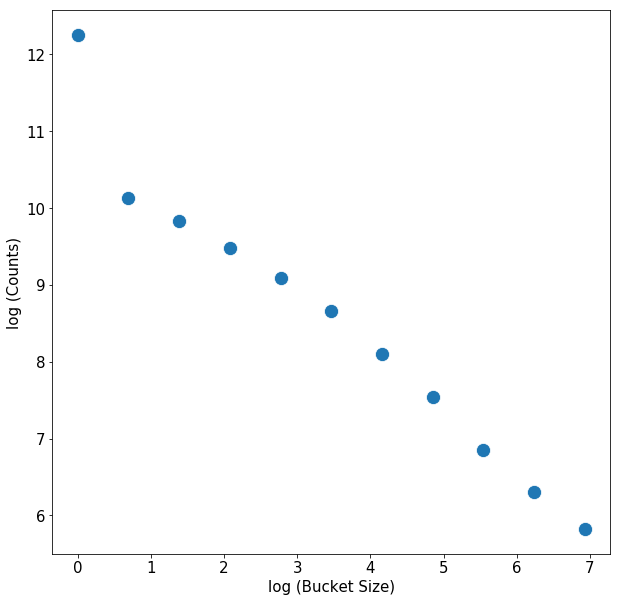

In [67]:
x, y = zip(*feature_counts_buckets)
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 15})
ax=sns.scatterplot(x=np.log(x), y = np.log(y), ax=ax, s=200)
ax.set_xlabel("log (Bucket Size)"), ax.set_ylabel("log (Counts)")

The above figure characterizes the sparsity of the features in the data set. Note that this is a log-log plot. It is clear that majority of features only have smaller number of data points. Therefore, it does not make sense to use all features. We need to reduce the feature dimension drastically. This will increase the scalability of the algorithm without sacrificing the performance.

Without any dimension reduction, let us first use `LogisticRegressionWithLBFGS` from Spark mllib to characterize the baseline ROC as illustrated below.

In [13]:
start = time.time()
lrm_sample_train = LogisticRegressionWithLBFGS.train(train_sample_rdd_ohe, iterations=50)
print (f'... train sample data with 50 iterations in {time.time() - start} seconds.')

... train sample data with 50 iterations in 38.00198984146118 seconds.


In [14]:
print(lrm_sample_train.threshold)
print(len(lrm_sample_train.weights))

0.5
288289


In [14]:
start = time.time()
dev_sample_rdd = dev_rdd.sample(False, 0.01, 2019).cache()
print(f'# of test samples = {dev_sample_rdd.count()}')
dev_sample_rdd_ohe = dev_sample_rdd.map(lambda x: parse_with_label(x, sample_ctr_dict, sample_num_ctr_features))
dev_sample_rdd_ohe.cache()
print (f'... get one hot LabelPoint for test dev in {time.time() - start} seconds.')

# of test samples = 45608
... get one hot LabelPoint for test dev in 35.79230332374573 seconds.


In [21]:
start = time.time()
test_results = dev_sample_rdd_ohe.map(lambda x: (x.label, lrm_sample_train.predict(x.features)))
testErr = test_results.filter(lambda x: x[0] != x[1]).count() / float(test_results.count())
print(f"Sample test accuracy = {1-testErr}")
print (f'... complete prediction on sampled dev data in {time.time() - start} seconds.')

Sample test accuracy = 0.6816088958387629
... complete prediction on sampled dev data in 0.8345451354980469 seconds.


In [22]:
lrm_sample_train.clearThreshold()
test_labels_and_prob = dev_sample_rdd_ohe.map(lambda x: (x.label, lrm_sample_train.predict(x.features))).collect()

In [29]:
test_labels_and_prob.sort(key=lambda x: x[1], reverse=True)

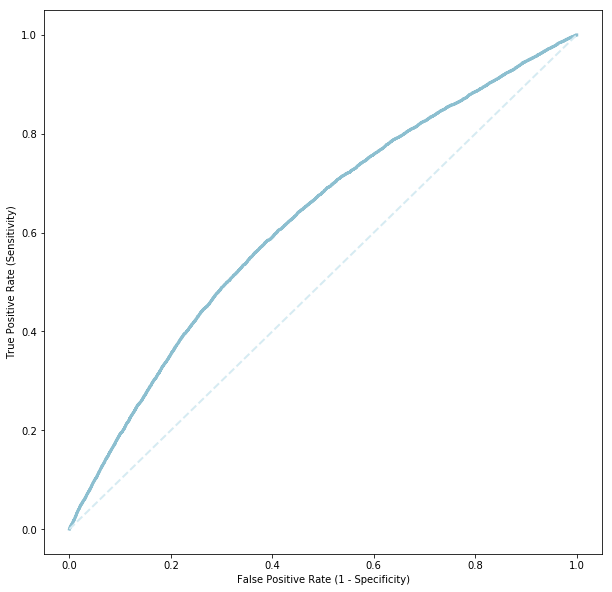

In [50]:
labels_by_weight = np.array([k for (k, v) in test_labels_and_prob])
length = labels_by_weight.size
true_positives = labels_by_weight.cumsum()
num_positive = true_positives[-1]
false_positives = np.arange(1.0, length + 1, 1.) - true_positives

true_positive_rate = true_positives / num_positive
false_positive_rate = false_positives / (length - num_positive)


# Generate layout and plot data
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 15})
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(false_positive_rate, true_positive_rate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)

The above ROC curve visualizes how well the model predicts the target. It shows us the trade-off between the false positive rate and true positive rate, as we vary the threshold required to predict a positive outcome. A random model is represented by the dashed line. With full set of features, it is better than random model but it is also not very strong either.  It is also less accuracte than the null rate we would have by guessing "not-clicked" every time, of 75%.


## Major data Challenge mitigation strategy

### Method of Feature Hashing

We have seen above that we have a mostly empty sparse feature set. In this situation, feature hashing is a useful technique for handling sparse, high-dimensional features in this machine learning problem. It is going to allow us to design a fast, simple, memory-efficient, and well-suited Logistical regression model that can be used in this online learning scenario. Below we wil also build the data pipeline using the RDD framework, this will help us demonstrate the distributed nature of the underlying algorithm.

Benefits of feature hashing:

1) Handles sparse data pipelines consistently, irrespective of new categorical values.
2) Keeps the overall dimensions to be static-- we can set this-- hence limiting effect of sparsity.
3) Computationally very efficient, we can predict now using the number of rows the time and space complexity of the algorithm

# 4. Methods

__[this section needs to have each of the methods we tried - our design and implementations]__
__[the following is just a sample, needs to be revised]__

In this section, we will implement homegrown logistic regression with gradient descent, as described in Section 2. Based on the insights from EDA, we first need to implement the hashing trick to bound the number of features in our one-hot encoding. To compare our homegrown implementation, we use the off-the-shelf logistic regression solver from Spark MLlib.

## Reduce features with feature hashing trick

### The RDD API based approach
The following functions provide the hashing of features based on the feature ID. This approach utilizes base RDD API and no machine learning scala libraries from Spark. 

In [13]:
from collections import defaultdict
import hashlib

def feature_hashing(num_dimensions, original_features, verbose=False):
    """
    Args:
        num_dimensions (int): Number of buckets to use as features.
        original_features (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        verbose (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the dimensions that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for idx, category in original_features:
        feature_str = (category + str(idx)).encode('utf-8')
        mapping[feature_str] = int(int(hashlib.md5(feature_str).hexdigest(), 16) % num_dimensions)
    if(verbose):
        print (f'mapping is {mapping}.')
    hashed_features = defaultdict(float)
    for d in mapping.values():
        hashed_features[d] += 1.0
    return dict(hashed_features)

def parse_to_hashed_LabeledPoint(line, num_dimensions):
    """
    Args:
        line (str): A comma separated string where the first value is the label and the rest are
            features.
        num_dimensions: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    features = parse(line)
    items = line.split(',')
    label = items[0]
    features_hashed = feature_hashing(num_dimensions, features, verbose=False)
    return LabeledPoint(label, SparseVector(num_dimensions, features_hashed))

First, let us test the hashing function with our toy example and verify its correctness with manual checking as shown below.

In [53]:
print(f'100 dimensions hashed dict for toy example: {feature_hashing(100, toy_dict.keys(), True)}.\n')
print(f'10 dimensions hashed dict for toy example: {feature_hashing(10, toy_dict.keys(), True)}.\n')
print(f'5 dimensions hashed dict for toy example: {feature_hashing(5, toy_dict.keys(), True)}.')

mapping is {b'url11': 33, b'url21': 90, b'user20': 6, b'url31': 66, b'user10': 90}.
100 dimensions hashed dict for toy example: {33: 1.0, 90: 2.0, 6: 1.0, 66: 1.0}.

mapping is {b'url11': 3, b'url21': 0, b'user20': 6, b'url31': 6, b'user10': 0}.
10 dimensions hashed dict for toy example: {3: 1.0, 0: 2.0, 6: 2.0}.

mapping is {b'url11': 3, b'url21': 0, b'user20': 1, b'url31': 1, b'user10': 0}.
5 dimensions hashed dict for toy example: {3: 1.0, 0: 2.0, 1: 2.0}.


To compare the sparsity of the hashed features and non-hashed features, we now apply hashing trick to our sample data as illustrated below. The number of hashed dimensions is bounded at $2^{15} = 32,768$.

In [12]:
ctr_dimensions = 2 ** 15
train_sample_rdd_hashed = train_sample_rdd.map(lambda x: parse_to_hashed_LabeledPoint(x, ctr_dimensions))
train_sample_rdd_hashed.cache()
print (train_sample_rdd_hashed.take(1))

[LabeledPoint(0.0, (32768,[250,3668,4822,5093,5302,7114,7998,9985,10624,10633,11722,12090,12143,12433,13910,14339,14780,14872,15609,15816,16814,17062,17716,19274,19370,20103,21604,21659,21890,22284,24746,25201,25533,25882,26656,29152,31663,32475,32708],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [56]:
def compute_sparsity(rdd, d, n):
    """Calculates the average sparsity for the features in an RDD of LabeledPoints.

    Args:
        data (RDD of LabeledPoint): The LabeledPoints to use in the sparsity calculation.
        d (int): The total number of features.
        n (int): The number of observations in the RDD.

    Returns:
        float: The average of the ratio of features in a point to total features.
    """
    return float(rdd.map(lambda x: len(x.features.indices)).sum()) / d / n

In [59]:
num_train_samples = train_sample_rdd.count()
mean_sparse_hashed = compute_sparsity(train_sample_rdd_hashed, ctr_dimensions, num_train_samples)
mean_sparse_ohe = compute_sparsity(train_sample_rdd_ohe, sample_num_ctr_features, num_train_samples)

print (f'Average hashed sparsity: {mean_sparse_hashed}')
print (f'Average OHE sparsity: {mean_sparse_ohe}')

Average hashed sparsity: 0.0011806893013603088
Average OHE sparsity: 0.00013514871556739936


As we reduced the number of dimensions of the sampled data from $288,289$ to hashed $32,768$ dimensions, the average of the ratio of features in a point to total features is increased by one order of magnitude from $1.35\times 10^{-4}$ to $1.1\times 10^{-3}$. Therefore, the sparsity is reduced.

In [15]:
dev_sample_rdd_hashed = dev_sample_rdd.map(lambda x: parse_to_hashed_LabeledPoint(x, ctr_dimensions))
start = time.time()
lrm_sample_train_hashed_data = LogisticRegressionWithLBFGS.train(train_sample_rdd_hashed, iterations=50)
print(f'Length of hashed weight vector: {len(lrm_sample_train_hashed_data.weights)}.')
test_results_hashed = dev_sample_rdd_hashed.map(lambda x: (x.label, lrm_sample_train_hashed_data.predict(x.features)))
testErr_hashed = test_results_hashed.filter(lambda x: x[0] != x[1]).count() / float(test_results_hashed.count())
print(f"Sample hashed test accuracy = {1-testErr_hashed}")
print (f'... train hashed sample data with 50 iterations in {time.time() - start} seconds.')

Length of hashed weight vector: 32768.
Sample hashed test accuracy = 0.6703648482722329
... train hashed sample data with 50 iterations in 59.799105167388916 seconds.


As we reduced the number of dimensions of the sampled data from $288,289$ to hashed $32,768$ dimensions, we reduced sparsity as shown earlier. However, __the accuracy remains about the same $0.68$ vs $0.67$__ as shown here.

### Logistic Regression(Homegrown) with Gradient Descent

We are now ready to implement our homegrown logistic regression described on Section 2. The gradient update function is straight forward and it directly maps to equation (2). We apply map-reduce programming using RDDs.

The mapper function calculates the gradient. Based on equation (2), the gradient is just an updated vector $x_i$ with scalar. Since we use the sparse vector representation, we only need to multiply the scalar to the one hot values of the $x_i$.

To complete the gradient step, there is a step to sum over all sparse vectors over all data points. This step turns out to be very challenging to optimize. First, we tried the Spark built-in function `mean()`, but the computation time is too long. Then, we wrote several specialized functions for adding these sparse vectors that yield limited improvements. Finally, we applied `aggregate` function and let `numpy` perform the vector summation. Our last approach improved the run time by 100 times. However, when we compare with the native `Scala` implementation, our `python` based approach is still about 6 times slower.

Note that we did not implement the stochastic gradient descent since the default MLlib fraction of data for gradient descent is 1. We mainly focus on GD with full data pass in each iteration.

In the following, we present our results for both homegrown and Spark `MLlib` on the full training set and test set.

In [14]:
def negative_log_likelihood_loss(dataRDD, W):
    """
    Compute mean squared error.
    Args:
        dataRDD - LabeledPoint
        W       - (array) model coefficients
    Returns:
        loss
    """
    def calc_loss(x):
        ret = np.log(1+ np.exp(- x.features.dot(W))) + (1-x.label)*x.features.dot(W)
        return ret
    loss = dataRDD.map(calc_loss).mean()
    return loss

In [15]:
from collections import defaultdict
from pyspark.mllib.linalg import Vectors

def GD_update_wReg(dataRDD, W, n, ctr_dimensions, learningRate = 0.1, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge regularization.
    Args:
        dataRDD - LabeledPoint
        W       - (array) model coefficients
        learningRate - (float) defaults to 0.1
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients
    """
    new_model = None
    def calc_gradient(x):
        scalar = ((1./(1+np.exp(-x.features.dot(W)))-x.label))
        x.features.values = scalar*x.features.values
        return x.features
    grad = dataRDD.map(calc_gradient).aggregate(np.zeros(ctr_dimensions),
                                                lambda acc, b: acc + b.toArray(),
                                                lambda acc, b: acc + b)
    grad = grad/n
    grad = grad + 2*regParam*W
    new_model = W -learningRate * grad
    return new_model

In [27]:
def GradientDescent_wReg(trainRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regParam = 0.1, ctr_dimensions=2**15, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # perform n updates & compute test and train loss after each
    model = wInit
    trainRDD = trainRDD.cache()
    n = float (trainRDD.count())
    for idx in range(nSteps):
        print(f"STEP: {idx+1}.")
        model = GD_update_wReg(trainRDD, model, n, ctr_dimensions, learningRate, regParam)
        
        #if verbose:
        #    loss = negative_log_likelihood_loss(trainRDD, model)
        #    print(f"STEP: {idx+1}, loss = {loss}.")
    return model

In [17]:
def LogisticRegression_RDD_predict(features, W, threshold = 0.5):
    prob = 1./(1+np.exp(-features.dot(W)))
    if (prob >= threshold):
        return 1.0
    else:
        return 0.0

We first verify and test our homegrown implementation with sample data set and sample test set as shown below.

In [20]:
wInit = np.zeros(ctr_dimensions)
train_sample_model = GradientDescent_wReg(train_sample_rdd_hashed, wInit, nSteps = 50, ctr_dimensions=wInit.size,  verbose=False)
test_results_homegrown = dev_sample_rdd_hashed.map(lambda x: (x.label, LogisticRegression_RDD_predict(x.features, train_sample_model))).cache()
testErr_homegrown = test_results_homegrown.filter(lambda x: x[0] != x[1]).count() / float(test_results_homegrown.count())
print(f"Sample homegrown LR test accuracy = {1-testErr_homegrown}")
print(f"\n... trained 50 iterations with homegrown LR and sample data in {time.time() - start} seconds")

Sample homegrown LR test accuracy = 0.7447377653043326

... trained 50 iterations with homegrown LR and sample data in 265.1284329891205 seconds


#### MLlib.LogisticRegressionWithLBFGS Implementation (full train and test data)

First, we prepare our full training data and test data with one hot coding and feature hash trick.

In [18]:
ctr_dimensions = 2 ** 15
train_rdd_hashed = train_rdd.map(lambda x: parse_to_hashed_LabeledPoint(x, ctr_dimensions)).cache()
dev_rdd_hashed = dev_rdd.map(lambda x: parse_to_hashed_LabeledPoint(x, ctr_dimensions)).cache()

In [19]:
train_rdd_hashed.take(1)

[LabeledPoint(0.0, (32768,[1305,2883,3807,4814,4866,4913,6952,7117,9985,10316,11512,11722,12365,13893,14735,15816,16198,17761,19274,21604,22256,22563,22785,24855,25202,25533,25721,26487,26656,27668,28211,29152,29402,29873,30039,31484,32493,32708],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]

In [20]:
dev_rdd_hashed.take(1)

[LabeledPoint(0.0, (32768,[250,2069,2627,2817,5725,6357,7697,7762,9745,10188,11558,11722,12136,12629,12945,13026,13606,14296,14597,15048,17341,18011,18023,18689,18793,19274,20601,21604,22011,23039,23149,24234,25533,25818,26384,27095,28107,28211,28405],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]

In [21]:
start = time.time()
lrm_mllib_final = LogisticRegressionWithLBFGS.train(train_rdd_hashed, iterations=50)
print (f'... MLlib train hashed full data with 50 iterations in {time.time() - start} seconds.')

... MLlib train hashed full data with 50 iterations in 1005.9435801506042 seconds.


The MLlib completed the training with full data set as shown above. The run time is $1006$ seconds. We also computed the accuracy with test data set at $0.78$.

In [23]:
start = time.time()
test_results_mllib_final = dev_rdd_hashed.map(lambda x: (x.label, lrm_mllib_final.predict(x.features)))
testErr_mllib_final = test_results_mllib_final.filter(lambda x: x[0] != x[1]).count() / float(test_results_mllib_final.count())
print(f"Final test accuracy with MLlib = {1-testErr_mllib_final}")
print (f'... MLlib final full test in {time.time() - start} seconds.')

Final test accuracy with MLlib = 0.78114392463063
... MLlib final full test in 9.716737031936646 seconds.


In [26]:
lrm_mllib_final.save(sc, 'gs://w261-data-gp/notebooks/lrm_mllib_final')

In the following, we use our homegrown logistic regression implementation to train the model with full training data set. The run time is $6806$ seconds with accuracy of $0.74$ on the test data.

In [28]:
start = time.time()
wInit = np.zeros(ctr_dimensions)
train_homegrown_model = GradientDescent_wReg(train_rdd_hashed, wInit, nSteps = 50,
                                             ctr_dimensions=wInit.size, verbose=False)

print(f"\n... trained 50 iterations with homegrown LR of full train data in {time.time() - start} seconds")

STEP: 1.
STEP: 2.
STEP: 3.
STEP: 4.
STEP: 5.
STEP: 6.
STEP: 7.
STEP: 8.
STEP: 9.
STEP: 10.
STEP: 11.
STEP: 12.
STEP: 13.
STEP: 14.
STEP: 15.
STEP: 16.
STEP: 17.
STEP: 18.
STEP: 19.
STEP: 20.
STEP: 21.
STEP: 22.
STEP: 23.
STEP: 24.
STEP: 25.
STEP: 26.
STEP: 27.
STEP: 28.
STEP: 29.
STEP: 30.
STEP: 31.
STEP: 32.
STEP: 33.
STEP: 34.
STEP: 35.
STEP: 36.
STEP: 37.
STEP: 38.
STEP: 39.
STEP: 40.
STEP: 41.
STEP: 42.
STEP: 43.
STEP: 44.
STEP: 45.
STEP: 46.
STEP: 47.
STEP: 48.
STEP: 49.
STEP: 50.

... trained 50 iterations with homegrown LR of full train data in 6806.3908133506775 seconds


In [29]:
start = time.time()
test_results_homegrown_final = dev_rdd_hashed.map(lambda x: (x.label, LogisticRegression_RDD_predict(x.features, train_homegrown_model))).cache()
testErr_homegrown = test_results_homegrown_final.filter(lambda x: x[0] != x[1]).count() / float(test_results_homegrown_final.count())

print(f"Homegrown LR final test accuracy = {1-testErr_homegrown}")
print (f'... Homegrown final full test in {time.time() - start} seconds.')

Homegrown LR final test accuracy = 0.743893677221343
... Homegrown final full test in 5.412996530532837 seconds.


### Benchmark A: Spark ML with homegrown hashing function

The following shows the results of using `LogisticRegression` from `pyspark.ml.classification`.

In [12]:
from pyspark.sql.functions import *
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors

#### Hashing with DataFrames

The following implementation of hashing is using the same hashing MD5 function, however there are some critical differences we must note, making this more efficient:

(1) Keep the number of dimensions same, this helps comparing the models an apples to apples comparison.    
(2) As this uses the Spark 2.0 DataFrames based ML library, we can use the new data pipeline format - `Label, Sparse Vector[features]`    
(3) DataFrames were built using Parquet files and on the multi node cluster, the DataFrame is split over 50+ partitions.    
(4) Even on the full dataset the hashing function takes only about 60 seconds to process 45.8 Million rows.    

In [21]:
from collections import defaultdict
from pyspark.sql import Row
import hashlib

def hashing(dims, row, verbose=False):
    """
    Args:
        dims (int): Number of buckets to use as features.
        row (dict of (feature name, str)): A list of named features for an observation.  Represented as
            (featureID, value) tuples.
        verbose (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the dimensions that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for idx, category in row.items():
        if idx != 'Label':
            feature_str = (str(category) + str(idx)).encode('utf-8')
            mapping[feature_str] = int(int(hashlib.md5(feature_str).hexdigest(), 16) % dims)
        else:
            label = category
    
    features = defaultdict()
    for d in mapping.values():
        features[d] = 1.0
            
    #return dict(hashed_features)
    return (float(label),  Vectors.sparse(dims,dict(features)))

The following data chunks were stored separately and below is the evidence that while the samples could be processed on a sandbox, the full dataset was processed on a pre-production grade Google Cloud Data Proc cluster.

In [17]:
#RUN ON DATA PROC ONLY ONCE
#toyDF = spark.read.parquet("gs://w261-schakraverty-bucket/notebooks/toy_sample.parquet")
#F1DF = spark.read.parquet("gs://w261-schakraverty-bucket/notebooks/train_sample.parquet")
FullDF = spark.read.parquet("gs://w261-schakraverty-bucket/notebooks/train.parquet")

In [19]:
FullDF.count()

45840617

(2) Convert the feature vector into the hashed feature vector space for all the datasets

In [45]:
## HASHING TRICK - Toy Training set
struct = toyDF_T.columns
dims = 2 ** 15
toyDF_TH = toyDF_T.rdd.map(lambda row: dict(zip(struct,row))) \
                      .map(lambda x: hashing(dims,x,False)) \
                      .toDF(['label','features'])

In [46]:
## ## HASHING TRICK - Toy Validation set

struct = toyDF_V.columns
dims = 2 ** 15
toyDF_VH = toyDF_V.rdd.map(lambda row: dict(zip(struct,row))) \
                      .map(lambda x: hashing(dims,x,False)) \
                      .toDF(['label','features'])

(3) Train and validate the Toy dataset

In [47]:
## Train the model using Toy Training Data
start = time.time()

lr = LogisticRegression(maxIter=50, regParam=0.01)
modelt = lr.fit(toyDF_TH)

## Validate the model using Toy Training Data
prediction = modelt.transform(toyDF_VH)
result = prediction.select("label", "prediction") \
    .cache()

testErr = result.filter(result.label!=result.prediction).count() / float(result.count())
print(f"Toy Validation accuracy = {1-testErr}")
print (f'... Toy data with 50 iterations in {time.time() - start} seconds.')

Toy Validation accuracy = 0.72
... Toy data with 50 iterations in 5.134096622467041 seconds.


(4) Hashing of the F1 dataset

In [48]:
## HASHING TRICK - Sample Training set
struct = F1DF_T.columns
dims = 2 ** 15
F1DF_TH = F1DF_T.rdd.map(lambda row: dict(zip(struct,row))) \
                      .map(lambda x: hashing(dims,x,False)) \
                      .toDF(['label','features'])

In [49]:
## ## HASHING TRICK - Sample Validation set

struct = F1DF_V.columns
dims = 2 ** 15
F1DF_VH = F1DF_V.rdd.map(lambda row: dict(zip(struct,row))) \
                      .map(lambda x: hashing(dims,x,False)) \
                      .toDF(['label','features'])

(5) Training of the F1 dataset using Logistical regression

In [13]:
## Train the model using F1 Training Data
start = time.time()

lr = LogisticRegression(maxIter=50, regParam=0.01)
modelf = lr.fit(F1DF_TH)

## Validate the model using F1 Training Data
prediction = modelf.transform(F1DF_VH)
result = prediction.select("label", "prediction") \
    .cache()

testErr = result.filter(result.label!=result.prediction).count() / float(result.count())
print(f"Sample Validation accuracy = {1-testErr}")
print (f'...Sample data with 50 iterations in {time.time() - start} seconds.')

Sample Validation accuracy = 0.7146691719232318
...Sample data with 50 iterations in 34.270079612731934 seconds.


We can obtain the coefficients by using LogisticRegressionModel’s attributes. We can see the $\beta$ coefficients of the 30k features in the model.

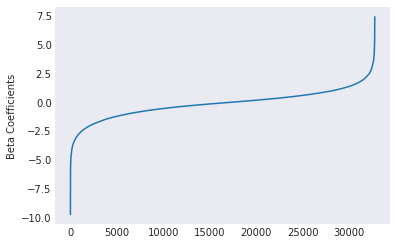

In [14]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(modelf.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

### Model Performance measure


We summarize the model over the F1 set, we can obtain the receiver-operating characteristic and area under the ROC (AUC - ROC).

AUC - ROC curve is the performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.

The ROC curve below is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis. This can change based on the business threshold for specificy and hence effect the sensitivity.

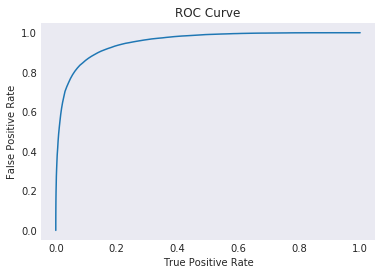

Training set areaUnderROC: 0.9527498955367195


In [16]:
trainingSummary = modelf.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

#### Interpretation of the ROC plot

In a ROC curve the false positive rate is plotted as a function of the true positive rate (Sensitivity) for different cut-off points of a parameter. The area under the ROC curve ( AUC ) is a measure of how well a parameter can distinguish between two diagnostic groups (click/non-click)<sup>[14](https://www.medcalc.org/manual/roc-curves.php)</sup>. We can see that we have a model that has an acceptable level of (online) ability to diagnose and tell our marketing client the probability of a click vs no click.   



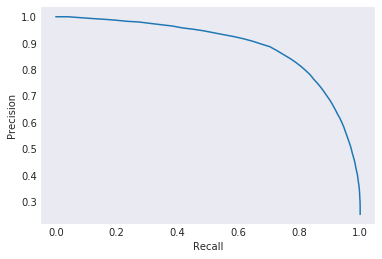

In [17]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### Interpretation of the Recall Vs Precision curve

The precision-recall plot is based on two basic measures – recall and precision -- that are calculated from the four outcomes. The precision-recall plot uses recall on the x-axis and precision on the y-axis. Recall is identical with sensitivity, and precision is identical with positive predictive value. 

A point of caution.

Saito and Rehmsmeier (2015)<sup>[8](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432)</sup> found in a literature analysis that ROC curves are very popular, their popularity has been increasing for the last decade, and they are the most widely used evaluation method with imbalanced data. Based on their models for how to compare performance the authors conclude that changing the main evaluation method from ROC to PRC may influence he usefulness of prediction performance measures like ROC or RPC.

The graphs presented for the data sets above clearly demonstrate that adding a lot of observations without a click and with low click rate to a model may improve the ROC curve significantly without any improvement in sensitivity or in positive predictive value of the parameter evaluated. 

The precision-recall curves will not be impacted by the addition of more observations without a click and with low click rates. Thus it can be highly recommended to use PRC as a supplement to the routinely used ROC curves to get the full picture when evaluating and comparing performance of the model.

### Full Dataset

In [22]:
## HASHING TRICK - FULL Training set -- (RUN ON DATA PROC ONLY)
struct = FullDF_T.columns
dims = 2 ** 15
FullDF_TH = FullDF_T.rdd.map(lambda row: dict(zip(struct,row))) \
                      .map(lambda x: hashing(dims,x,False)) \
                      .toDF(['label','features'])

In [23]:
## ## HASHING TRICK - FULL Validation set -- (RUN ON DATA PROC ONLY)

struct = FullDF_V.columns
dims = 2 ** 15
FullDF_VH = FullDF_V.rdd.map(lambda row: dict(zip(struct,row))) \
                      .map(lambda x: hashing(dims,x,False)) \
                      .toDF(['label','features'])

In [26]:
## Train the model using FULL Training Data -- (RUN ON DATA PROC ONLY)
start = time.time()

lr = LogisticRegression(maxIter=50, regParam=0.01)
model = lr.fit(FullDF_TH)

## Validate the model using FULL Training Data
prediction = model.transform(FullDF_VH)
result = prediction.select("label", "prediction") \
    .cache()

testErr = result.filter(result.label!=result.prediction).count() / float(result.count())
print(f"FULL training set Validation accuracy = {1-testErr}")
print (f'...Full training data with 50 iterations in {time.time() - start} seconds.')

FULL training set Validation accuracy = 0.7817834221245549
...Full training data with 50 iterations in 694.7876329421997 seconds.


#### Distributed computing benefit illustrated

The following two cells show how the data itself is distributed over 63 partitions across the worker nodes, using all the worker nodes. This helps the model train much faster and is the core selling point of Spark over a standalone model. Given the large dimension space, this dataset will have a very hard time running even when we scale up on a standalone machine, rather scaling out as needed is entirely feasible.

In [37]:
FullDF_TH.rdd.getNumPartitions()


63

In [38]:
FullDF_VH.rdd.getNumPartitions()

28

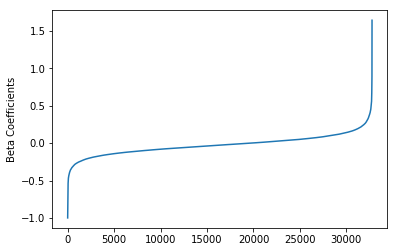

In [27]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(model.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

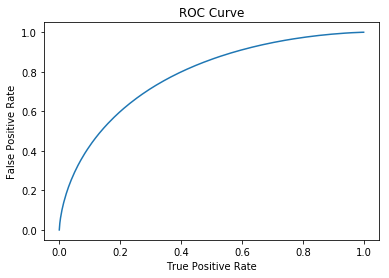

Training set areaUnderROC: 0.78004798354049


In [28]:
trainingSummary = model.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

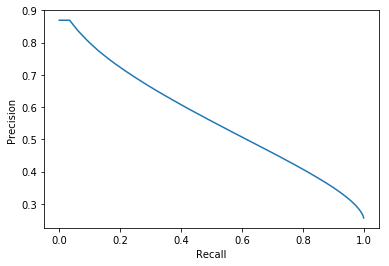

In [29]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### Log loss on the full training and validation set

In [31]:
def log_loss(trueLabel, predProb, eps = 1e-15):
    p = np.clip(predProb, eps, 1 - eps)
    if (trueLabel == 1):
        return -np.log(p)
    else:
        return -np.log(1-p)

In [36]:
#Mean log loss on full dataset [ From Scott's Notebook]
meanLogLoss = prediction.select(['label', 'probability']).rdd.\
    map(lambda x: (x[0], x[1][0])).\
    map(lambda x: log_loss(x[0], x[1])).sum()\
    / prediction.count()

print(f'Mean log loss: {meanLogLoss}')

Mean log loss: 1.546261771468331


In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.652513836749881


Optional : Training F1 dataset using the Naive Bayes disributed ML model...(to add more explanation, implementation)

In [44]:
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel

## Train the model using Sample Training Data
start = time.time()

from pyspark.ml.classification import NaiveBayes

# Train a NaiveBayes model
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

modelnb = nb.fit(F1DF_TH)

## Validate the model using Toy Training Data
prediction = modelnb.transform(F1DF_VH)
result = prediction.select("label", "prediction") \
    .cache()

testErr = result.filter(result.label!=result.prediction).count() / float(result.count())
print(f"Sample Validation accuracy (NB) = {1-testErr}")
print (f'...Sample data with 50 iterations in {time.time() - start} seconds.')

Sample Validation accuracy (NB) = 0.7020534156489062
...Sample data with 50 iterations in 22.90907073020935 seconds.


In [45]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.529507390040488


#### Optional : Training Full dataset using the Naive Bayes distributed ML model...

[Ng and Jordan](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjqrI7O6tXhAhVms1QKHV6xDnkQFjAAegQIARAC&url=https%3A%2F%2Fai.stanford.edu%2F~ang%2Fpapers%2Fnips01-discriminativegenerative.pdf&usg=AOvVaw1lDX-Rqo3NwkYjfERkK3IK)<sup>[21]</sup> compare the benefits of the discriminative and generative learning, i.e. Logistical regression and Naive Bayes respectively. 

They show the detailed mathamatical proof of the following very important property: We notice here that the Naive Bayes classifier manages to converge more quickly to it's (higher) asymptotic error. However, the trainign time in iteself is not the only criteria, what we also understand is that while Naive Bayes initially appears to be doing better, the discriminiative Logistical regression will eventually catch up as the number of training examples will continue to increase. Logistical regression would be expected to overtake Naive Bayes. We keep the folllling example 



In [39]:
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel

## Train the model using Sample Training Data
start = time.time()

from pyspark.ml.classification import NaiveBayes

# Train a NaiveBayes model
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

modelnb = nb.fit(FullDF_TH)

## Validate the model using Toy Training Data
prediction = modelnb.transform(FullDF_VH)
result = prediction.select("label", "prediction") \
    .cache()

testErr = result.filter(result.label!=result.prediction).count() / float(result.count())
print(f"Sample Validation accuracy (NB) = {1-testErr}")
print (f'...Sample data with 50 iterations in {time.time() - start} seconds.')

Sample Validation accuracy (NB) = 0.7099160800266101
...Sample data with 50 iterations in 597.4028360843658 seconds.


NOTE : The above Naive Bayes algorithm was no longer used in favor of the more robust Logistical regression with regularization, thus improving the particular model. We focused on the Logistical Regression model due to it's accuracy, stability and robust parameters as the number of traning samples increase.

In [20]:
# RUN ON DATA PROC ONLY - Create FULL training and Validation set from Training set
splits = FullDF.randomSplit([0.8,0.2],2019)
FullDF_T , FullDF_V= splits[0] , splits[1]
FullDF_T.count() , FullDF_V.count()

(36670947, 9169301)

In [22]:
## HASHING TRICK - FULL Training set -- (RUN ON DATA PROC ONLY)
struct = FullDF_T.columns
dims = 2 ** 15
FullDF_TH = FullDF_T.rdd.map(lambda row: dict(zip(struct,row))) \
                      .map(lambda x: hashing(dims,x,False)) \
                      .toDF(['label','features'])

In [23]:
## ## HASHING TRICK - FULL Validation set -- (RUN ON DATA PROC ONLY)

struct = FullDF_V.columns
dims = 2 ** 15
FullDF_VH = FullDF_V.rdd.map(lambda row: dict(zip(struct,row))) \
                      .map(lambda x: hashing(dims,x,False)) \
                      .toDF(['label','features'])

In [26]:
## Train the model using FULL Training Data -- (RUN ON DATA PROC ONLY)
start = time.time()

lr = LogisticRegression(maxIter=50, regParam=0.01)
model = lr.fit(FullDF_TH)

## Validate the model using FULL Training Data
prediction = model.transform(FullDF_VH)
result = prediction.select("label", "prediction") \
    .cache()

testErr = result.filter(result.label!=result.prediction).count() / float(result.count())
print(f"FULL training set Validation accuracy = {1-testErr}")
print (f'...Full training data with 50 iterations in {time.time() - start} seconds.')

FULL training set Validation accuracy = 0.7817834221245549
...Full training data with 50 iterations in 694.7876329421997 seconds.


#### Benchmark A : Spark 2.0 ML implementation summary

Our business user ultimately wants a solution that can achieve their goals, while the Data science team can take advantage of the most stable generally available features of Spark that can be handed off the the Dev Ops organization for continued maintenance. From approximately 2015 on, Apache Spark's core development team implemented an umbrella project called Tungsten to overhaul Spark's execution engine<sup>10</sup>. Concurrently, the Catalyst optimizer was introduced in 2015<sup>11</sup> We recognize the following key facts of using Spark's latest ML and DataFrames abstraction libraries:

(1) Ease-of-use of APIs with structure - Although DataFrame structure may limit control in what the Spark program can do with data, it introduces rich semantics and an easy set of domain specific operations that can be expressed as high-level constructs. Most computations, however, can be accomplished with DataFrame's high-level APIs. (it’s much simpler to perform agg, select, sum, avg, map, filter, or groupBy operations than using RDD rows’ data fields.)<sup>[15](https://www.kdnuggets.com/2017/08/three-apache-spark-apis-rdds-dataframes-datasets.html)</sup>

(2) Performance and Optimization - Along with all the above benefits, we cannot overlook the space efficiency and performance gains in using DataFrames and Dataset APIs for two reasons. First, because DataFrame and Dataset APIs are built on top of the Spark SQL engine, it uses Catalyst to generate an optimized logical and physical query plan. Across R, Java, Scala, or Python DataFrame/Dataset APIs, all relation type queries undergo the same code optimizer, providing the space and speed efficiency. Whereas the Dataset[T] typed API is optimized for data engineering tasks, the untyped Dataset(row) (an alias of DataFrame) is even faster and suitable for interactive analysis.<sup>[16](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html)</sup>

(3) Modernization of the framework - The choice of RDD or DataFrame is NOT always easy one. RDD offers low-level functionality and control, the DataFrame allows custom view and structure, high-level and specific operations, saves space, and executes at superior speeds.

As we examined in this class, the lessons we learned from early releases of Hadoop streaming, RDDs
  — how to simplify Spark for developers, how to optimize and make it performant
  — we decided to elevate the low-level RDD APIs to a high-level abstraction as DataFrame and Dataset and to build this unified data abstraction across  libraries atop Catalyst optimizer and Tungsten.<sup>[18](https://datalere.com/databricks/5-things-to-know-about-databricks/)</sup>
  - Spark has been historically difficult to tune and maintain. That makes it very hard to ensure performance so that it doesn’t buckle under heavy data loads.  If the cluster isn’t expertly managed, this can negate “the Good” aspects fast.
  - PySpark UDFs are much slower and more memory-intensive than Scala and Java UDFs are. 
  - The performance skew towards Scala and Java is noticeable and appreciated, since Spark is written in Scala and runs on the Java Virtual Machine (JVM).<sup>[19](https://www.quora.com/What-is-the-difference-between-using-Spark-in-Scala-and-Python)</sup> 
  - Python UDFs require moving data from the executor’s JVM to a Python interpreter, which is very slow. If Python UDF performance is problematic, Spark does enable a user to create Scala UDFs, which can be run in Python. However, this slows down development time and was beyond the scope of this project.<sup>[17](https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html)</sup>


In Summary,

Apache Spark has released DataFrames and DataSets abstractions. They have also added several specific base algorithms in the machine learning libraries (MLlib and ML) and improved performance. Unfortunately, enterprises that need business continuity will be cautious to upgrade to more complex engineering centric solution creating a major bottleneck due to a constant need for highly skilled data engineers and Spark data scientists. As data scientists, we have had to cope with working on the Hadoop stream, then RDD and finally the DataFrames paradigm, making the progress to become faster and lot of error prone details to be abstracted out.<sup>[20](https://thenewstack.io/the-good-bad-and-ugly-apache-spark-for-data-science-work/)</sup>

We propose that for this project, we keep in mind that a model that is less complex, has greater parsimony, utilizes a framework that allows faster go-to-market and above all a distributed computing environment that is less prone to errors and resilient to the elastic nature of Big data challenges, is the key to success.


### Benchmark B: Spark ML and Spark Hash function

In [5]:
import pyspark.sql.functions as F

In [6]:
from pyspark.ml.feature import FeatureHasher
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression


In [8]:
raw_train_rdd = sc.textFile('gs://whimsy/data/train.txt', 2).map(lambda x: x.replace('\t', ','))

In [7]:
raw_train_rdd = sc.textFile('gs://w261-data-gp/data/train.txt', 2).map(lambda x: x.replace('\t', ','))

In [21]:
#train_sample = raw_train_rdd.sample(fraction=0.10, seed = 42, withReplacement= False)
RDD = raw_train_rdd.map(lambda x: x.split(','))
train_sample_df = RDD.toDF()

In [24]:
numDims = 2**15
W = np.random.randn(numDims, numDims)

#Reference http://wiki.fast.ai/index.php/Log_Loss

def my_log_loss(trueLabel, predProb, eps = 1e-15):
    p = np.clip(predProb, eps, 1 - eps)
    if (trueLabel == 1):
        return -np.log(p)
    else:
        return -np.log(1-p)
    


start = time.time()
print(f'Hashing to {numDims} dimensions')

hasher = FeatureHasher(numFeatures=numDims,
                       inputCols=train_sample_df.columns[1:],
                       outputCol="features")

featurized = hasher.transform(train_sample_df)
#featurized.show(truncate=False)

end = time.time()
print(f'Hashing completed job in {end - start} seconds.')

start = time.time()
print('Fitting')

training = featurized.withColumn('label', featurized._1.cast('int'))


lr = LogisticRegression(maxIter=50,\
                        regParam=0.01,\
                        elasticNetParam=0.8,\
                        featuresCol='features',\
                       labelCol='label')

# Fit the model
lrModel = lr.fit(training)

end = time.time()
print(f'Fitting completed job in {end - start} seconds for 50 iterations.')


trainingSummary = lrModel.summary

objectiveHistory = trainingSummary.objectiveHistory
print("Objective History:")

for objective in objectiveHistory:
    print(objective)
    
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)


predictions = lrModel.transform(dataset=training)

#  mean log loss
meanLogLoss = predictions.select(['label', 'probability']).rdd.\
    map(lambda x: (x[0], x[1][0])).\
    map(lambda x: my_log_loss(x[0], x[1])).sum()\
    / predictions.count()

print(f'Mean log loss: {meanLogLoss}')


Hashing to 32768 dimensions
Hashing completed job in 0.14031076431274414 seconds.
Fitting
Fitting completed job in 288.1995451450348 seconds for 50 iterations.
Objective History:
0.5690695122717043
0.562927102648893
0.5403914208840935
0.5383135289922488
0.5370124175571116
0.5358635546808279
0.5349961606990863
0.5347969340503967
0.5345190181639797
0.5343388757291968
0.5340599892987344
0.5339632675039712
0.5338079855557321
0.533742303707672
0.5336732694796329
0.5336484992434946
0.5336321797467516
0.5336220008041086
0.5336165621511542
0.5336026622197877
0.533600303757809
0.5335889391389165
0.5335840536108487
0.5335803913477444
0.5335748287028189
0.5335679438875043
0.5335643313429337
0.5335605940260457
0.5335573418100674
0.5335539378054186
0.5335464075224362
0.5335425320759277
0.5335388133925143
0.5335352333275233
0.5335306893185437
0.5335290458809745
0.5335278494145177
0.5335249308689615
0.5335227896484618
0.5335212196804394
0.5335208636675725
0.5335188199140855
0.5335171084980285
0.53351

In [25]:
trainingSummary.accuracy

0.7602666866373112

### Benchmark C: Spark MLlib and MurmurHash function

Since One Hot Encoding of all the features in this dataset results in over 33 million dimensions, we wanted to explore the model performance when data is not one-hot-encoded. Below is the illustration of utilizing hashing and data normalization without one hot encoding. This approach retains the original dimensionality of 39 features. 

Containing dimensionality helps in faster performance. However, such computational performance should not undermine model performance. 

In [4]:
trainFile = sc.textFile('gs://w261-project-bucket/data/train.txt', 2)
testFile = sc.textFile('gs://w261-project-bucket/data/test.txt', 2) 
# Sample file was created using random 0.01 % of training data file
sampleFile =  sc.textFile('gs://w261-project-bucket/data/sample.txt', 2)

In [10]:
import mmh3 as mmh

In [4]:
from pyspark.mllib.regression import LabeledPoint
def parse(line):
    items = line.split("\t")
    return items

def featureHash(line):
    items = line.split("\t")
    # Ensure target is not hashed
    newLine = []
    for i, item in enumerate(items):
        if i == 0:
            newLine.append(int(item))
        else:
            newLine.append(mmh.hash(item))
    return LabeledPoint(newLine[0], newLine[1:])
    
def normalize(dataRDD):
    start = time.time()
    fMean = dataRDD.map(lambda x: x.features).mean()
    fSD = np.sqrt(dataRDD.map(lambda x: x.features).variance())
    
    nRDD = dataRDD.map(lambda x: LabeledPoint(x.label, (x.features - fMean)/fSD))
    
    return nRDD    

In [6]:
# Parse full training data 
start = time.time()
fullRDD = trainFile.map(featureHash)
print (f'Time to hash data: {time.time() - start} seconds.')

start = time.time()
fullHashRDD = normalize(fullRDD).cache()
print (f'Time to normalize data: {time.time() - start} seconds.')

# Split training data into training and test RDD with a 70:30 split
trainRDD, testRDD = fullHashRDD.randomSplit([.7,.3], seed=7)
trainRDD.cache()
testRDD.cache()

Time to hash data: 8.0108642578125e-05 seconds.
Time to normalize data: 223.0287230014801 seconds.


PythonRDD[16] at RDD at PythonRDD.scala:49

### Spark MLLib Evaluation Full data

MLLib model performance was at approx 74.4 % accuracy with test data when features are not normalized. Normalizing features has made performance much worse. However, normalizing data improves the time taken to train & test data.

The homegrown model, however, performs significantly better in terms of accuracy (at ~74%) although suffers in terms of time taken to generate a response. 

In [23]:
start = time.time()
hModel = LogisticRegressionWithLBFGS.train(trainRDD_Hashed, iterations=50)

# Evaluate model on Training data without normalizing
trainingPredictions_Hashed = trainRDD_Hashed.map(lambda line: (line.label, hModel.predict(line.features)))
trainErr_Hashed = trainingPredictions_Hashed.filter(lambda lp: lp[0] != lp[1]).count() / float(trainRDD_Hashed.count())
print(f'Training Error is: {str(trainErr_Hashed)} and accuracy is: {str(1 - trainErr_Hashed)}.')
print (f'Time to train data: {time.time() - start} seconds.')

start = time.time()

# Evaluate model on Test data
testPredictions_Hashed = testRDD_Hashed.map(lambda line: (line.label, hModel.predict(line.features)))
testErr_Hashed = testPredictions_Hashed.filter(lambda lp: lp[0] != lp[1]).count() / float(testRDD_Hashed.count())
print(f'Testing Error is: {str(testErr_Hashed)} and accuracy is: {str(1 - testErr_Hashed)}.')
print (f'Time to Test data: {time.time() - start} seconds.')

Training Error is: 0.2557397838929348 and accuracy is: 0.7442602161070653.
Time to train data: 269.92262983322144 seconds.
Testing Error is: 0.25604189040134256 and accuracy is: 0.7439581095986574.
Time to Test data: 65.47434186935425 seconds.


In [13]:
start = time.time()
lModel = LogisticRegressionWithLBFGS.train(trainRDD, iterations=50)

# Evaluate model on Training data
trainingPredictions = trainRDD.map(lambda line: (line.label, lModel.predict(line.features)))
trainErr = trainingPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(trainRDD.count())
print(f'Training Error is: {str(trainErr)} and accuracy is: {str(1 - trainErr)}.')
print (f'Time to train data: {time.time() - start} seconds.')

start = time.time()

# Evaluate model on Test data
testPredictions = testRDD.map(lambda line: (line.label, lModel.predict(line.features)))
testErr = testPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(testRDD.count())
print(f'Testing Error is: {str(testErr)} and accuracy is: {str(1 - testErr)}.')
print (f'Time to Test data: {time.time() - start} seconds.')

Training Error is: 0.40945115836647006 and accuracy is: 0.5905488416335299.
Time to train data: 181.8348867893219 seconds.
Testing Error is: 0.4092979987396704 and accuracy is: 0.5907020012603297.
Time to Test data: 19.773133039474487 seconds.


#### Homegrown model with murmurhash & normalization

In [9]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def logLikelihood(dataRDD, W):
    augmentedData = dataRDD.map(lambda x: (x.label, np.append([1.0], x.features)))
    def cost(data):
        y = data[0]
        x = data[1]
        return ((y * np.log(sigmoid(W.dot(x)))) + (1-y)*(np.log(1-sigmoid(W.dot(x)))))
    logLoss = -augmentedData.map(cost).mean()
    return logLoss    

def gradientUpdate(dataRDD, W, learningRate, regParam):
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (x.label, np.append([1.0], x.features))).cache()
    grad = augmentedData.map(lambda x: (sigmoid(W.dot(x[1])) - x[0]) * x[1]).mean()
    grad += regParam * np.append([0.0], np.sign(W)[1:])
    new_model = W - learningRate * grad
    return new_model   

def hgLogisticRegression(trainRDD, testRDD, W, learningRate = 0.1, regParam = 0.5, iterations = 5, verbose = True):
    # initialize lists to track model performance
    trainHistory, testHistory, modelHistory = [], [], []
    hgModel = W
    for idx in range(iterations):
        hgModel = gradientUpdate(trainRDD, hgModel, learningRate, regParam)
        trainingLoss = logLikelihood(trainRDD, hgModel)
        testingLoss = logLikelihood(testRDD, hgModel)

        trainHistory.append(trainingLoss)
        testHistory.append(testingLoss)
        modelHistory.append(hgModel)

        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {trainingLoss}")
            print(f"test loss: {testingLoss}")
            print(f"Model: {[round(w,3) for w in hgModel]}")
    
    return trainHistory, testHistory, modelHistory

def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss , testLoss
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    if title:
        plt.title(title)
    plt.show()
    


### Home grown model on sample data

In [11]:
start = time.time()
sampleModel = np.zeros(40)
trainSampleErr, testSampleErr, models = hgLogisticRegression(normRDD, testRDD, sampleModel, 0.1, 0.5, 50, False)
print (f'Time taken on sample data: {time.time() - start} seconds.')

Time taken on sample data: 1652.0397686958313 seconds.


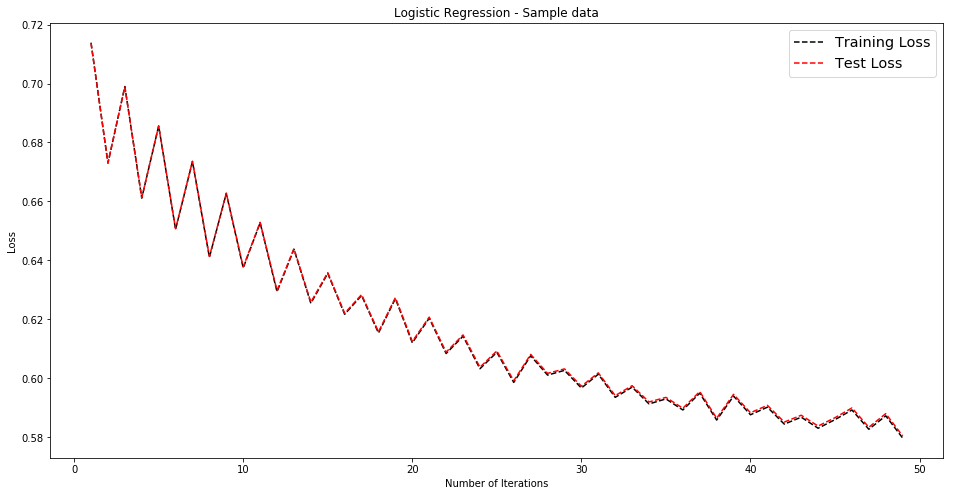

In [12]:
plotErrorCurves(trainSampleErr, testSampleErr, title = 'Logistic Regression - Sample data' )

### Home grown model on full data

In [17]:
start = time.time()
hgModel = np.zeros(40)
trainErr, testErr, regModels = hgLogisticRegression(trainRDD, testRDD, hgModel, 0.1, 0.5, 50, False)
print (f'Time taken on full data: {time.time() - start} seconds.')

Time taken on full data: 5955.500848531723 seconds.


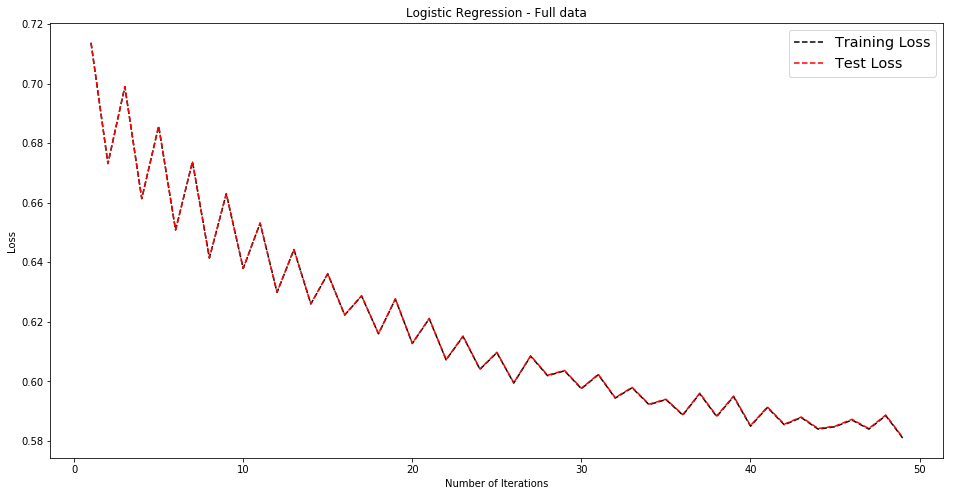

In [18]:
plotErrorCurves(trainErr, testErr, title = 'Logistic Regression - Full data' )

In [71]:
pred_homegrown = testRDD.map(lambda x: (x.label, LogisticRegression_RDD_predict(np.append([1.0], x.features), regModels[-1]))).cache()
testErr_homegrown = pred_homegrown.filter(lambda x: x[0] != x[1]).count() / float(pred_homegrown.count())
print(f"Full Data homegrown LR test accuracy = {1-testErr_homegrown}")

Full Data homegrown LR test accuracy = 0.7435562232336266


## Model with k-fold Cross Validation

k-fold cross validation is a well established approach to reduce model bias and variance. The approach trains a model iteratively k-times by dividing data into k datasets, holding out the k<sup>th</sup> set for testing and using the rest for training. Bias is reduced by ensuring each data point is in test set exactly one time while the model error is computed across all k trials.<sup>[22]</sup>  

K-Fold cross validation takes the following steps<sup>[23]</sup>:
1.	Shuffle the dataset randomly.
2.	Split the dataset into k groups
3.	For each unique group:  
    3.1.	Take the group as a hold out or test data set  
    3.2.	Take the remaining groups as a training data set  
    3.3.	Fit a model on the training set and evaluate it on the test set  
    3.4.	Retain the evaluation score and discard the model
4.	Summarize the skill of the model using the sample of model evaluation scores

The downside of this approach however is the time it takes to train the model. Since the model executes k times, model training can take a very long time. As such, below execution was performed only on the sample dataset. The full dataset execution did not complete despite training on cluster node setup for 24 hours. This execution was terminated due to resource cnstraints.

In [13]:
def kResiduals(dataPoint, models, splitNum):
    """
    Compute the residuals for a data point given k different models.
    Note that points from the k-th split are part of the test set for model number k
    and part of the trainin set for all other models. We'll emit a key to track this.
    Args:
        dataPoint - tuple of (features_array, y)
        models    - list of arrays representing model weights (bias at index 0)
    Returns:
        (stringFormattedKey, squared_error)
    """
    # augment the data point with a bias term at index 0
    X = np.append([1.0], dataPoint.features)
    y = dataPoint.label
    # emit squared residuals for each model
    for modelNum, W in enumerate(models):
        if modelNum == splitNum:
            yield(f"{modelNum}-test", ((- y * np.log(sigmoid(W * X))) - (1-y)*(np.log(1-sigmoid(W * X)))))
        else:
            yield(f"{modelNum}-train", ((- y * np.log(sigmoid(W * X))) - (1-y)*(np.log(1-sigmoid(W * X)))))
            

def CVLoss(dataSplits, models):
    """
    Compute the k-fold cross-validated test and train loss.
    Args:
        dataSplits - list of RDDs corresponding to the k test splits.
        models     - list of k arrays representing model weights (bias at index 0)
    Returns: 
        tuple of floats: (training_loss, test_loss)
    """
    # compute k residuals for each dataPoint (one for each model)
    partialLossRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        residuals = splitRDD.flatMap(lambda x: kResiduals(x, models, splitNum))
        partialLossRDD = sc.union([partialLossRDD, residuals])
    
    loss = partialLossRDD.mapValues(lambda x: (x,1))\
                         .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                         .mapValues(lambda x: x[0]/x[1])\
                         .collect()
    
    test_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'test'])
    training_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'train'])
    return training_loss, test_loss

def partialGradients(splitNum, dataPoint, models):
    """
    Emit partial gradient for this data point for each model.
    NOTE: a data point from split-number k is in the test set for 
    model-k so we don't compute a partial gradient for that model.
    """
    # augment the data point
    X = np.append([1.0], dataPoint.features)
    y = dataPoint.label
    # emit partial gradients for each model with a counter for averaging later
    for modelNum, W in enumerate(models):
        if modelNum != splitNum:
            yield (modelNum, [(sigmoid(W.dot(X)) - y)*X, 1])

def CVUpdate(dataSplits, models, learningRate = 0.1):
    """
    Compute gradients for k models given k corresponding dataSplits.
    NOTE: the training set for model-k is all records EXCEPT those in the k-th split.
    """
    # compute partial gradient k-1 times for each fold
    partialsRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        thisFoldPartialGrads = splitRDD.flatMap(lambda x: partialGradients(splitNum, x, models))
        partialsRDD = sc.union([partialsRDD, thisFoldPartialGrads])

    # compute gradients by taking the average partialGrad for each fold
    gradients = partialsRDD.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                           .mapValues(lambda x: x[0]/x[1])\
                           .map(lambda x: x[1])\
                           .collect()
    
    # update all k models & return them in a list
    new_models = []
    for W, grad in zip(models, gradients):
        new_models.append(W - learningRate * grad)
    return new_models

def GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 5, verbose = False):
    """
    Train k models in parallel and track cross validated test/train loss.
    Returns:
        train_hist - (list) of floats
        test_hist - (list) of floats
        model_hist - (list) of arrays representing model coefficients (bias at index 0)
    """
    # broadcast initial models (one for each fold)
    bModels = sc.broadcast([wInit] * len(dataSplits))
    
    # initialize lists to track performance
    train_loss_0, test_loss_0 = CVLoss(dataSplits, bModels.value)
    train_hist, test_hist, model_hist = [train_loss_0], [test_loss_0], [wInit]
    
    # perform k gradient updates at a time (one for each fold)
    start = time.time()
    for step in range(nSteps):
        new_models = CVUpdate(dataSplits, bModels.value, learningRate)
        bModels = sc.broadcast(new_models)

        # log progress
        train_loss, test_loss = CVLoss(dataSplits, bModels.value)
        train_hist.append(train_loss)
        test_hist.append(test_loss)
        model_hist.append(new_models[0])
        
        if verbose:
            print("-------------------")
            print(f"STEP {step}: ")
            print(f"model 1: {[round(w,4) for w in new_models[0]]}")
            print(f" train loss: {round(train_loss,4)}")
            print(f" test loss: {round(test_loss,4)}")
            
    print(f"\n... trained {nSteps} iterations in {time.time() - start} seconds")
    return train_hist, test_hist, model_hist

In [19]:
start = time.time()
dataSplits = normRDD.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed = 2018) 
wInit = np.zeros(40)
trainLossSample, testLossSample, modelsSample = GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 50, verbose=False)
print (f'Time taken to Cross Validate on sample data: {time.time() - start} seconds.')


... trained 50 iterations in 753.6316719055176 seconds
Time taken to Cross Validate on sample data: 769.2351448535919 seconds.


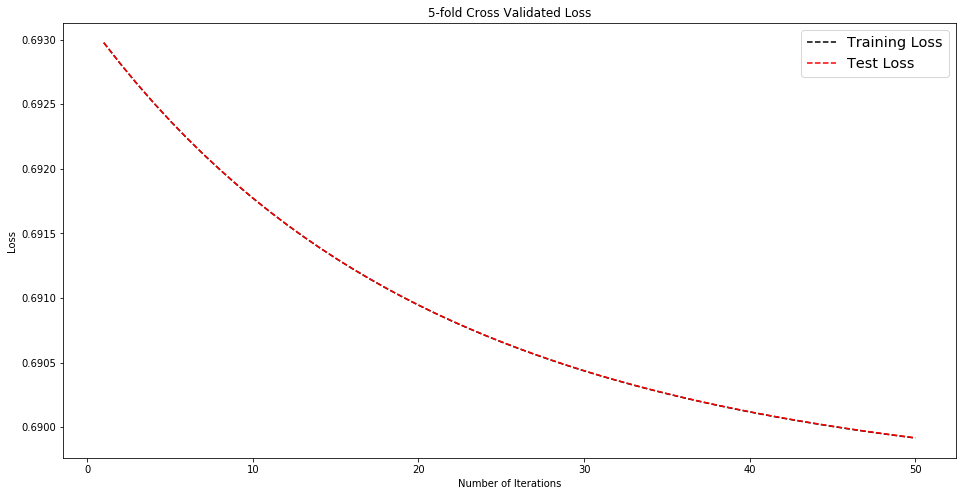

In [20]:
plotErrorCurves(trainLossSample, testLossSample, title = '5-fold Cross Validated Loss' )

In [72]:
pred_CV = testRDD.map(lambda x: (x.label, LogisticRegression_RDD_predict(np.append([1.0], x.features), modelsSample[-1]))).cache()
testErr_CV = pred_CV.filter(lambda x: x[0] != x[1]).count() / float(pred_CV.count())
print(f"Sample homegrown LR test accuracy = {1-testErr_CV}")

Sample homegrown LR test accuracy = 0.7436127839412955


# 5. Application of New Concepts

__{This section needs to be updated to reflect a list of all the things we tried and what we learned]__

Throughout the project we sought to implement a scalable solution with consideration to the business context.  Logistic regression was chosen as a solution known to scale well, with desirable characteristics due to the linear nature of its underlying formulation, which would translate to roughly linear time complexity and the ability to scale out effectively in a distributed environment.  With regularization it becomes an extension of ridge or LASSO regression, with all the desirable properties thereof in a distributed framework.  Logistic regression also has an explainable formulation and can be fitted with gradient descent, so solution convergence can be tuned according to known hyperparameters such as learning rate.

The dataset provided challenges related to feature sparsity. With logistic regression categorical features must be converted to a numerical interpretation.  One-hot-encoding the feature set could not provide a scalable solution due to the combinatorics associated with large numbers of categories per feature, and we therefore chose to hash the feature set.  The feature hash mapped the feature set to a bounded space, provided a framework for handling unseen data per feature, and could be tuned either to map each feature individually to a new space (as in our homegrown solutions), or to map the entire feature set as a whole to a new space, as with Spark's built-in hash.  The former would allow for further feature selection or the ability to drop features providing minimal information, while the latter allows the usage of all information and a fast implementation.  One drawback is that hashing adds an additional hyperparameter, the size of the new space, which could require tuning.

The algorithm was developed atop the RDD API, using the map/reduce paradigm, allowing for control of each detail of the implementation, but at a cost of speed vs. either the Spark MLLib  or ML implementation. In the case of MLLib, we lose efficiency due to Python being slower than Scala.  In the case of the ML library, further improvements by the Apache Spark project to the query optimizer mean still further gains in speed, considerably outpacing our implementation, but at the cost of less transparency to the inner workings of the algorithm.

As a useful control against overfitted models, we built the implementation with the ability to apply and tune regularization.  While the default Spark implementation allows for $L_1$ or $L_2$ regularization we have only included $L_2$ for now.  We did not explore tuning the regularization hyperparameter, but it provides an important control against possible bias associated with using a large number of features.

<h5><center> Summary of performance with 50 iterations and $2^{15}$ hashed features.</center></h5>
 
|Feature Engineering|Implementation|Training time (seconds)|Test data accuracy|Comments|
|----- |---- |----|----|----|
|ML build-in hashing|ML   |288|0.76|Dataframe API|
|One-hot coding with homegrown hashing|MLlib| 1006|0.78| RDD, Scala implementation|
|One-hot coding with homegrown hashing|Homegrown|6806|0.74|RDD, Python implementation|


<h5 align="center">Summary of performance with 50 iterations and $39$ features.</h5>
 
|Feature Engineering|Implementation|Training time (seconds)|Test data accuracy|Comments|
|---- |---- |----|----|----|
|MMH | MLlib  |270|0.74|RDD, Scala Implementation|
|MMH & Data Normalization|MLlib| 182|0.59|RDD, Scala Implementation|
|MMH & Data Normalization|Homegrown|5955|0.74|RDD, Python implementation|
|MMH & Data Normalization|Homegrown Cross Validation|769 (sample data only)|0.74|RDD, Python implementation|


# 6. References

__[FULL LIST WILL BE UPDATED AS WE COMPLETE PROJECT]__

(1) [The State of Streaming Music Services](https://www.pcmag.com/roundup/260966/the-best-online-music-streaming-services)

(2) [Spotify - For the record](https://newsroom.spotify.com/company-info/)

(3) [Criteo website](https://www.criteo.com/)

(4) [Simplify advertising analytics click prediction with databricks unified analytics platform](https://databricks.com/blog/2018/07/19/simplify-advertising-analytics-click-prediction-with-databricks-unified-analytics-platform.html)

(5) [Simple and scalable response prediction for display advertising](https://www.dropbox.com/s/s4x7wp8gjsh021d/TISTRespPredAds-Chappelle-CTR-Prediction-2014Paper.pdf?dl+=0)

(6) [Parquet for Spark-SQL](https://developer.ibm.com/hadoop/2015/12/03/parquet-for-spark-sql/)

(7) [Click-Through Rate Prediction Lab](https://datascience-enthusiast.com/Python/cs120_lab3_ctr_df_celloutput.html)

(8) [The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432)

(9) [Understanding AUC ROC](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

(10) [Spark Streaming](https://databricks.com/blog/2016/07/28/structured-streaming-in-apache-spark.html)

(11) [ML with Pyspark](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

(12) [Project Tungsten: Improving the Efficiency of Spark Applications](https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html)

(13) [Deep Dive into Spark SQL's Catalyst Optimizer](https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html)

(14) [Interpretation of the ROC plot](https://www.medcalc.org/manual/roc-curves.php)

(15) [RDD Vs DataFrames](https://www.kdnuggets.com/2017/08/three-apache-spark-apis-rdds-dataframes-datasets.html))

(16) [Differences - RDD & DataFrames](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html))


(17) [Spark SQL Documentation](https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html))

(18) [Databricks Blog - RDD Vs DataFrames](https://datalere.com/databricks/5-things-to-know-about-databricks/)

(19) [Spark in Scala Vs Python](https://www.quora.com/What-is-the-difference-between-using-Spark-in-Scala-and-Python) 

(20) [Spark - Pros and Cons of the Platform](https://thenewstack.io/the-good-bad-and-ugly-apache-spark-for-data-science-work/)

(21) [Discriminative vs Generative classifiers by Ng and Jordan](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjqrI7O6tXhAhVms1QKHV6xDnkQFjAAegQIARAC&url=https%3A%2F%2Fai.stanford.edu%2F~ang%2Fpapers%2Fnips01-discriminativegenerative.pdf&usg=AOvVaw1lDX-Rqo3NwkYjfERkK3IK)
(22) [CS.CMU.EDU](https://www.cs.cmu.edu/~schneide/tut5/node42.html)
(23) [Machine Learning Mastery](https://machinelearningmastery.com/k-fold-cross-validation/)


## Code snippet references

(1) [Randomly pick lines from a file without slurping it with unix](https://stackoverflow.com/questions/692312/randomly-pick-lines-from-a-file-without-slurping-it-with-unix)

(2) [Click-through rate prediction](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2799933550853697/1070943937512584/2202577924924539/latest.html)

(3) [Log loss](http://wiki.fast.ai/index.php/Log_Loss)

(4) [Classification and Regression](https://spark.apache.org/docs/2.1.1/ml-classification-regression.html)

(5) [pyspark.ml package - Pyspark documentation](https://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression)



In [54]:
!gsutil cp final_project_workbook.ipynb gs://266-schakraverty

Copying file://final_project_workbook.ipynb [Content-Type=application/octet-stream]...
AccessDeniedException: 403 Insufficient Permission                              
